In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats 
import pandas as pd
import numpy as np
from operator import itemgetter
import statsmodels
import statsmodels.api as sm


In [3]:
import matplotlib
matplotlib.use('nbagg') # enables interactive figures, where we can zoom and move

In [4]:
# a couple more configuration of the plotting engine
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=18)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Convention and definition of the problem for linear model

The problem we are interested in is the following:

We have measured a bunch of variables per individual, for $n$ individuals. 
We are interested in the relationship between one of this variable that we will call the **response variable** 
and the other variables that we will call **covariables**.

Let's illustrate this with the "diabetes" dataset, grabbed from Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf).

It is described as : 
"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."


In [5]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

#this is our response variable
response=pd.DataFrame(diabetes['target'],columns=['disease progression'])
response.head()

,disease progression
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [6]:
## this is our covariable
covar=pd.DataFrame(diabetes['data'],columns=diabetes['feature_names'])
covar.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641



From a mathematical standpoint, we note the response variable vector $\pmb{y}$, and $\pmb{y}_i$ is a single element of that vector (*ie.* the reponse variable measured on a single individual).

Similarly, $\pmb X$ is the matrix of shape $(n,p)$ which contains the values of covariables. 
$\pmb{X}_i$ is a row in this matrix, which corresponds to the measures of the $p$ covariables for individual $i$.

\begin{equation*}
\pmb X = 
\begin{bmatrix}
X_{1,1} & X_{1,2} & ... & X_{1,p} \\
X_{2,1} & X_{2,2} & ... & X_{2,p} \\
 ... \\
X_{n,1} & X_{i,2} & ... & X_{n,p} \\
\end{bmatrix}
 ,\pmb y = 
\begin{bmatrix}
y_{1} \\
y_{2} \\
 ... \\
y_{n} \\
\end{bmatrix}
\end{equation*}

Furthermore, we will consider our response variable to actually be a random variable.
So each $y_i$ is in fact a realisation of a random variable $\pmb Y_i$.

Indeed our measurements are not perfect so there is some noise associated to it ($\epsilon$) : this why we decided to consider our response variable as a random variable. In mathematical term we are interested in a class of problem that we can write as :

$$\pmb{Y}_i=f(\pmb{X}_i)+\epsilon$$

The function $f$ is called the regression function, and today we will be interested in looking at a particular form of those function: **linear combination**.

A particular case of linear combination would be a single covariable with an intercept like :

$$y_i=\beta X_{i,1}+c$$

A more general case would have more covariables and would be written like:

$$f(\textbf{X}_i,\pmb{\beta})=\sum_{j} \beta_j X_{i,j}= \textbf{X}_{i}^{T}\pmb{\beta}$$

Where *$\pmb X_i$* is a vector of $p$ covariables associated to point individual $i$. And $\pmb{\beta}$ is a vector of $p$ coefficients (one for each covariable).

Note that for now nothing is said about the nature of the $X_{i,j}$. For example, some could be constant instead of being a variable (in that specific case they may as well be integrated in the $c$ constant).


In the case of our diabetes example, the response variable is $diseaseprogression$ and the covariables are 
$age , 	sex , bmi , bp, s1 , s2 , s3 , s4 , s5 , s6$.

So in the end, 
we are interested in finding a set of coefficients $\pmb \beta$ so that:

$$disease progression_0=\beta_1 age_0 + \beta_2 sex_0+\beta_3 bmi_0+\beta_4 bp_0+\beta_5 s1_0 +\beta_6 s2_0 + \beta_7 s3_0+\beta_8 s4_0+\beta_9 s5_0+\beta_10 s6_0+\beta_0$$

$$disease progression_1=\beta_1 age_1 + \beta_2 sex_1+\beta_3 bmi_1+\beta_4 bp_1+\beta_5 s1_1 +\beta_6 s2_1 + \beta_7 s3_1+\beta_8 s4_1+\beta_9 s5_1+\beta_10 s6_1+\beta_0$$

$$......$$

$$disease progression_n=\beta_1 age_n + \beta_2 sex_n+\beta_3 bmi_n+\beta_4 bp_n+\beta_5 s1_n+\beta_6 s2_n + \beta_7 s3_n+\beta_8 s4_n+\beta_9 s5_n+\beta_10 s6_n+\beta_0$$

Let's say for now we are only interest in $bmi$ (Body Mass Index) to predict disease progression. 
Then the kind of outcome we want of this analysis is our ability to understand the data linearly like that, which can be summarized by our ability to produce this kind of plots:

<IPython.core.display.Javascript object>


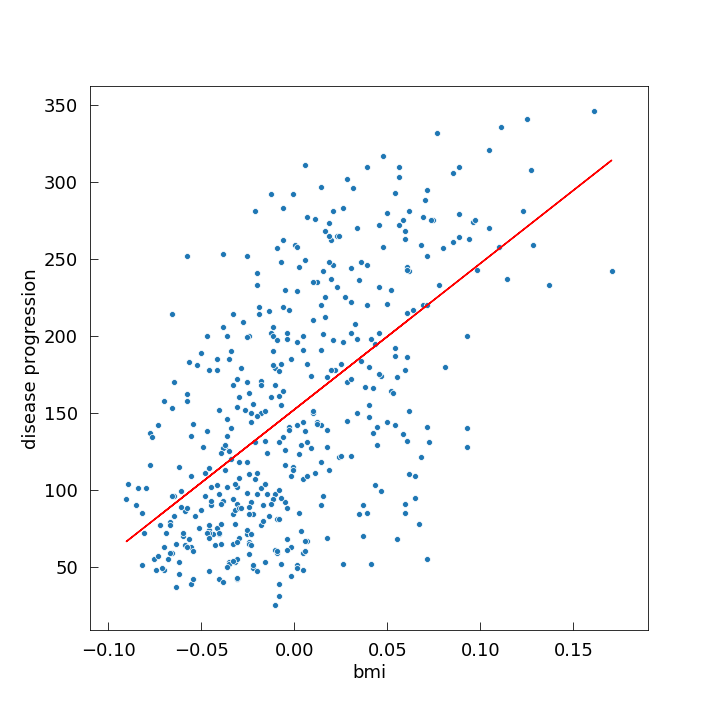

slope also called beta in our notation=  949.4352603839493
intercept also called c in our notation=  152.1334841628967


In [7]:
#pulling all the data together in the same dataFrame
df_diabetes = pd.concat([pd.DataFrame(diabetes['data'],columns=diabetes['feature_names']),\
                       pd.DataFrame(diabetes['target'],columns=['disease progression'])],axis=1)

x = df_diabetes['bmi'] # covariable bmi
y = df_diabetes['disease progression'] # response variable disease progression


fig, ax = plt.subplots( figsize = (10,10)) #setup graphical windows
sns.scatterplot(x,y) # plot x versus y

#linear regression explaining disease progression thanks to bmi
slope , intercept , r , pval , stderr = stats.linregress(x,y)
##don't mind how we did the regression for now, this is just for showcasing
print("slope also called beta in our notation= ",slope)
print("intercept also called c in our notation= ",intercept)

#now that we have the outcome iof the regression which is in this case a slope and
#an intercept we can calulate what the model will predict as a disease progression given a bmi value
yPredict = x * slope + intercept 

ax.plot( x , yPredict , color = 'red')#the outcome of the regression is this red line

So of course now the game become to best choose the vector of parameters $\pmb{\beta}$. For that there are two main methods (sorry Bayesian people...):
- Least Square fit
- Maximum Likelihood

We will need both and thus explore both.

Underlying those different methods, there are different models:

- Linear Models
- Generalized Linear Models

The way we wrote the function linking $\pmb Y$ to $\pmb X$ above, have the noise term $\epsilon$ outside of the function. So one would say that this function only try to represent the mean of the response variable $\pmb Y$ along the curve. This is what we actually do in the framework of Linear Models : we only aim to fit the mean response thanks to a linear relationship using the covariables.

If instead of fitting linearly the mean of the response variable, we would linearly fit a transformed mean of the response variable, then we would be in the reign of Generalized Linear Models (at least almost: we would still be missing the use of the maximum likelihood method) . 

GLM is a powerful framework that goes beyond (many of) the Linear Models limitations and we will introduce it later on this course.

# 1. Least Square Method

In the least square method we are interested in making the smallest overall square error between our model and the response variable.

Typically we want to find the vector of parameters $\beta$ that minimizes the objective function :

$$S(\pmb\beta)=\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2=\sum_i \epsilon_i^2$$

Here the sum is over $n$, which counts the number of individuals.

in mathematical terms you are looking for :

$$\hat{\pmb\beta}=\text{arg min}_{\pmb\beta}S(\pmb\beta)$$


> The hat $\hat{.}$, is a notation we use to denote our estimate of the true value of something. So in that sense $\hat{\pmb\beta}$ is the estimate of the "real" coefficient values, and $\hat{Y}$ is the estimation of $Y$ given by our model (also called the model predictions).



Let's see how that work on a toy example 

## 1.1 Simple representation of the problem and how it is solved

#### Toy example

Let's play with a toy example where we know the solution. 

We simulate a response variable that can be written $y=3x$, so with a single covariable. We also add some gaussian noise on top of that. 

We are going to check if the Ordinary Least Square (OLS) method could actully find this coefficient of 3.

<IPython.core.display.Javascript object>


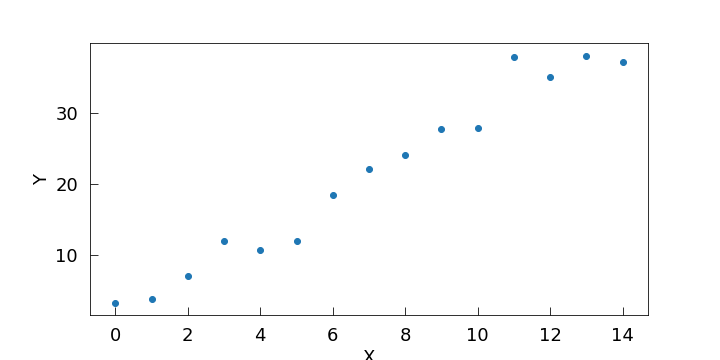

Text(0, 0.5, 'Y')

In [8]:
from matplotlib import collections  as mc

## let's create some data to play with 
slopeReal = 3 # the real slope is 3
noise = 3
x = np.arange(15) # 15 points for x
y = slopeReal * x + noise * np.random.randn(len(x)) # y = beta * x + some noise (no intercept here)

# plot the data
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(x,y, 'o' )
ax.set_xlabel("X")
ax.set_ylabel("Y")

**The challenge of least square regression is to find the slope that minimizes the squared error
let's try 3 possible values for the slope here : 2, 3 and 4**

<IPython.core.display.Javascript object>


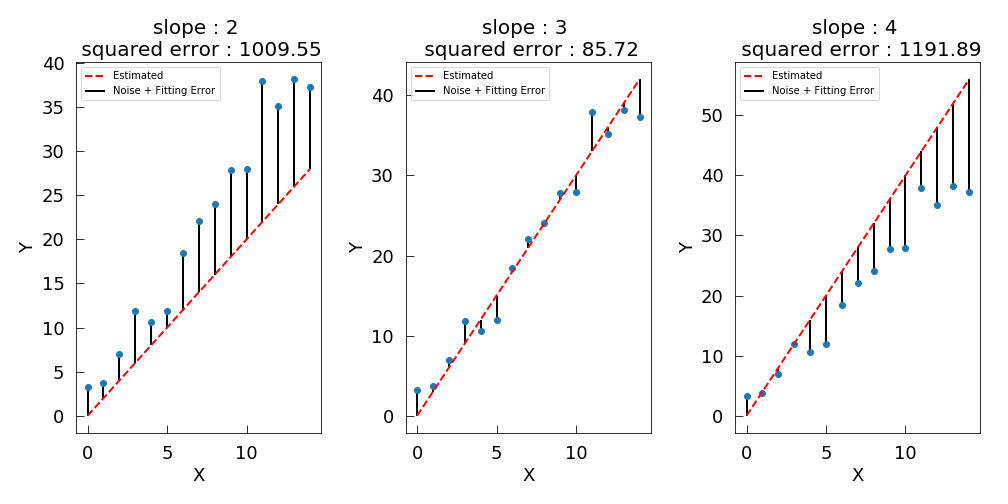

In [9]:

estimatedSlopes = [2,3,4]

fig, ax = plt.subplots(ncols=len(estimatedSlopes) , figsize = (14,7))

for i,slopeEstimate in enumerate(estimatedSlopes): # for each slope we want to test
    
    yPredicted = slopeEstimate * x # prediction of y given the estimated slope and values of x

    # error of the prediction -> sum of squared difference between observation and prediction
    predictionSquaredError = sum( ( yPredicted - y )**2 ) 

    #base plot
    ax[i].plot(x,y, 'o')
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    
    ax[i].plot(x,yPredicted, 'r--' , linewidth=2,label='Estimated') #plotting the prediction

    # now, let's represent the fitting error as segments between real and estimated values
    Real = [i for i in zip(x,y)]
    Predicted = [i for i in zip(x,yPredicted)]
    lc = mc.LineCollection(zip(Real,Predicted) , colors='black',linewidths=2,label='Noise + Fitting Error')
    ax[i].add_collection(lc)
    
    ax[i].set_title('slope : {} \n squared error : {:.2f}'.format(slopeEstimate,predictionSquaredError) ,
                    fontsize=20)
    ax[i].legend(fontsize=10)
plt.tight_layout()


We can see that a slope of 3 yields a lower Sum of Squared Errors (SSE) than 2 or 4. 

We could try to generalize this approach and test a lot of possible slope and then choose the best one (the one giving the lowest SSE).

<IPython.core.display.Javascript object>


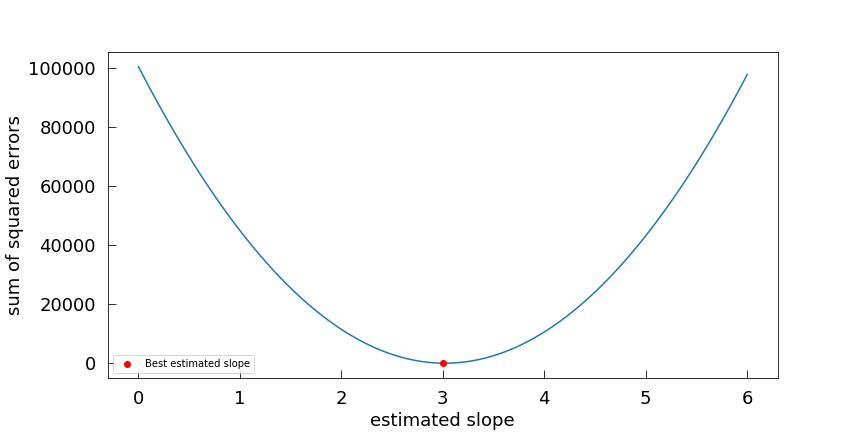

slope estimate with the smallest squared error (noise + fitting error) :  3.0


In [10]:
possibleSlopes = np.linspace(0,6,101)# trying a hundred slopes between 0 and 6
errors = []
for sl in possibleSlopes: # we compute the sum of squared error for each slopes
    yPred = sl*x
    errors.append( sum( yPred - y )**2 )

fitted_slope=possibleSlopes[ np.argmin( errors ) ] # we use np.argmin to find the best slope
min_err=min(errors)

#plotting 
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(possibleSlopes , errors )
ax.plot(fitted_slope , min_err,'ro' ,label='Best estimated slope')
ax.legend(loc='best',fontsize=10)

plt.xlabel('estimated slope')
plt.ylabel('sum of squared errors')
print( 'slope estimate with the smallest squared error (noise + fitting error) : ', fitted_slope )
#plt.tight_layout()

**Mini-exercice : what are the defaults of this method to find the best $\beta$ ?**


While we could use various optimization algorithms to find the best value for $\beta$, 
when the system is overdetermined (*i.e.*, you have more points than coefficients $\beta_i$) an analytical solution exists. It is of the form:

$$\hat{\pmb\beta}=(\pmb X^T \pmb X)^{-1}\pmb X^T \pmb Y$$


## 1.2.Underlying hypotheses of the Least Square fit

There are a couple of important hypothesis behind this method:

- **Correct specification** : have a good incentive for the function you use
- **Strict exogeneity** : the errors are centered around the true value of y
- **No linear dependance** : you can not reconstruct one of your covariable by summing a subset of your covariables with some set of constant weights 
- **Spherical errors**: 
    - Homoscedasticity : the spread of the error is the same along the curve.
    - No autocorrelation : error are not correlated along the curve.
        

        
To illustrate **Strict exogeneity** and **Spherical errors**, here is a plot of the errors on the diabetes model with $bmi$ :

<IPython.core.display.Javascript object>


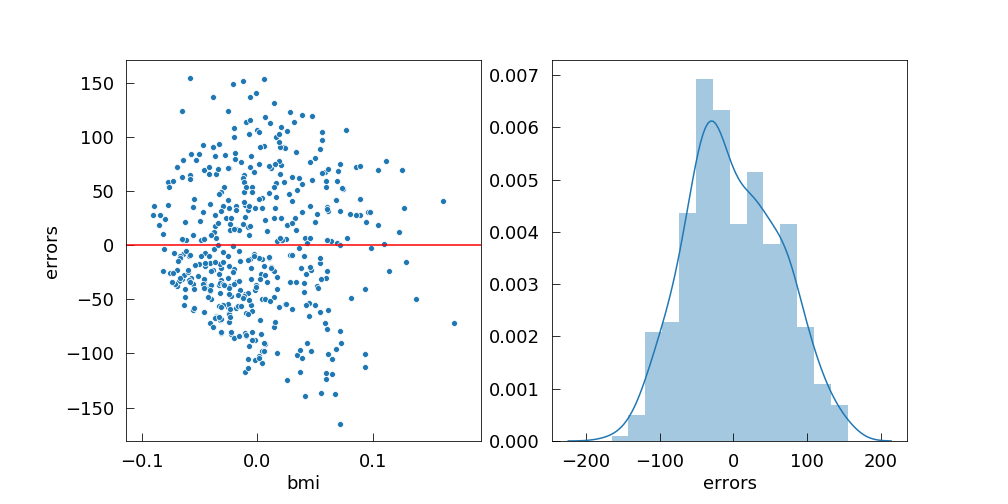

Text(0.5, 0, 'errors')

In [11]:
x = df_diabetes['bmi'] # covariable bmi
y = df_diabetes['disease progression'] # response variable disease progression
slope , intercept , r , pval , stderr = stats.linregress(x,y)

errors = y - (x*slope+intercept)

fig, ax = plt.subplots(ncols=2, figsize = (14,7)) #setup graphical windows
sns.scatterplot(x,errors , ax=ax[0]) # plot the errors along x
ax[0].axhline(0,color='red')
ax[0].set_ylabel('errors')
sns.distplot(errors , ax=ax[1]) # plot an histogram of the errors
ax[1].set_xlabel('errors')

The errors seems centered around 0 and there is no definite pattern that would allow us to reject outright the hypotheses of the Least Square fitting. We shall see later on how to actually test these using specific statistical tests.

The right panel also seems to suggest that our errors could follow something that looks like a normal distribution.
    
**Normality is not strictly needed for Least Square fitting, neither for the variables nor for their errors.** 
However you may need that hypothesis of normality of errors downstream in your analysis, in particular when using a test statistic to determinate the significance of your parameter


Additionnaly, if your errors are normally distributed, then Least Square fitting and Maximum Likelihood are equivalent, showing that your method for choosing $\pmb\beta$ is efficient and sound.

<!---We will quickly present the Maximum Likelihood equivalent as it is both a very useful technic and helps broadening linear models to Generalized Linear Models.-->

Finally, within that set of constraints and even if the method is called Linear Models, it is possible to fit polynomials of a degree bigger than 1. To do so you just have to precompute the monomials and add them to your set of covariables.

For example :

$y=\beta x +c$ is a linear combination of x

$y=\beta_{1}x+\beta_{2}x^{2}+\beta_{3}x^{3}$ is still a linear combination of covariables x, $x^{2}$ and $x^{3}$, and **X** becomes {$x,x^2,x^3$\}



## 1.3. Goodness of fit

By definiton, hte least square fit minimizes the Sum of Square Errors : $SSE=\sum (y_i-\hat{y_i})^2)$.

It is still important to assess the goodness of fit of your model, for instance to get an idea if you capture most of the variance of your response variable or to compare models between one-another.

The first metric use to do so is the Mean Square Error (MSE), which is defined as follow:

<br>

$$MSE=\frac{SSE}{n-2}$$ 

and accounts for what your model is missing. 
That could be the simple inherent variance induced by the noise term or the noise term and a missing term that your model doesn't take into account. By its nature, this metric makes it hard to compare between different hypothetical fitting models or different dataset.

A better normalized metric is the **adjusted coefficient of determination $\pmb R^2_a$**. 
The adjusted part is very necessary when we work in the context of multiple linear regression (more than one covariable). 

Let's start by defining the coefficient of determination $\pmb R^2$. 
This coefficient partitions the variance present in your data between what is taken into account by your model and what is not.

$$R^2=1-\frac{SSE}{SST}$$, where $SSE=\sum_i (y_i-\hat{y_i})^2$) and SST in the Sum of Squares Total ($\sum_i (y_i-\bar{y_i})^2$)

For the adjusted coefficient of determination you have to take into account that SSE and SST don't have the same degree of freedom and you should adjust for that.

$$R^2_a=1-\frac{n-1}{n-p}(1-R^2)$$, with $p$ the number of covariables and $n$ the number of individuals.

> Note : you can see that when there is only one covariable then $R^2_a = R^2$

In [12]:
SSE = sum( errors**2 )
MSE = SSE/(len(y)-2)
SST = sum( ( y - np.mean(y) )**2 )               # sum of square total
R2 =  1 - SSE/SST                                # coefficient of determination
R2a = 1 - ( (len(y)-1)/(len(y) - 2) ) * (1 - R2) # here, we have 2 parameters : intercept and slope for bmi
print( "bmi and disease progression model \n SSE:",SSE, "\n MSE :", MSE , "\n R2 :",R2 , "\n R2a :" , R2a)

bmi and disease progression model 
 SSE: 1719581.8107738828 
 MSE : 3908.140479031552 
 R2 : 0.3439237602253802 
 R2a : 0.34243267786225606


## 1.4. Confidence interval and test statistics

After your fitting, you would probably like to know the confidence interval for each of your estimated $\beta$, as well as if they are truly necessary (significantly different from zero). 
For both **you can't truly do anything without making an hypothesis about the statistic of the noise** : here comes the part where assuming your noise to be normally distributed ($N(0,\sigma^2)$) becomes important, but potentially wrong too.

For the confidence interval, if you have an infinite amount of data it is demostrated that the estimators are well described by a normal statistic. 
There is a convergence in the distribution so that $(\hat{\pmb\beta}-\pmb\beta)\rightarrow N(0,\sigma^2 (\pmb X^T \pmb X)^{-1})$). 

So for a big amount of points relative to the number of estimated parameters, you are not making a big mistake by writing the confidence interval of $\beta_i$ as:

$$\beta_j \in [\hat{\beta_j} \pm z_{1-\frac{\alpha}{2}}\sqrt{\hat{\sigma}^2 [(\pmb X^T \pmb X)^{-1}]_{j,j}}]$$ 

So in this formula, 
 * $j$ is indexing one of the covariable, 
 * $z_{1-\frac{\alpha}{2}}$ would be 1.96 for a 95% confidence interval, as you usually do with a normal distribution

If you don't have a huge amount of data you need to show that you have an incentive about your noise statistic to use these kind of confidence intervals (some libraries that we are going to use can do that for you!).


For the significance of the coefficients, **if you know that your noise is normally distributed then you can use a t-test**.

**Let's examine all these metrics for our simple model on the diabetes dataset**

In [13]:
## We'll be using the statsmodel package, which computes a lot of these metrics for you

X = sm.add_constant(x)## adding the intercept to the model
model = sm.OLS(y, X)  ## defining an Ordinary Least Square variable
results = model.fit() ## fitting it
res=results.summary()
print( res )

                             OLS Regression Results                            
Dep. Variable:     disease progression   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.342
Method:                  Least Squares   F-statistic:                     230.7
Date:                 Thu, 29 Oct 2020   Prob (F-statistic):           3.47e-42
Time:                         11:53:18   Log-Likelihood:                -2454.0
No. Observations:                  442   AIC:                             4912.
Df Residuals:                      440   BIC:                             4920.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.974     51.16

/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Let's go at these panels one by one.

In [14]:
print(res.tables[0])

                             OLS Regression Results                            
Dep. Variable:     disease progression   R-squared:                       0.344
Model:                             OLS   Adj. R-squared:                  0.342
Method:                  Least Squares   F-statistic:                     230.7
Date:                 Thu, 29 Oct 2020   Prob (F-statistic):           3.47e-42
Time:                         11:53:18   Log-Likelihood:                -2454.0
No. Observations:                  442   AIC:                             4912.
Df Residuals:                      440   BIC:                             4920.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         


The first panel gives you an overview of the fit quality:
* You recognize the good old **$R^2$** and **$R_a^2$**
* The **F-statistic** and its associated P-value (**Prob (F-statistic)**) tests the hypothesis that all the coefficients are 0 (under a normality assumption)
* **Log-likelihood** (normality assumption + this is the next big part so keep it on a corner of your mind)
* AIC and BIC, respectively **Aikike Information Criterion** and **Bayesian Information Criterion** are used (like the log-likelihood) for model comparison. You can use to compare non nested models. However they are, from my point of view less interpretable in the sense of what a threshold that you will put on those criterion means.

In [15]:
print(res.tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.974     51.162      0.000     146.289     157.978
bmi          949.4353     62.515     15.187      0.000     826.570    1072.301


The second panel presents the coefficient values and associated statistics.
 * **const** is the intercept. It represents the value of the response variable when all covariable are at 0.
 * **bmi** is the coefficient of the $bmi$. It represents the increase of the response variable when $bmi$ increases by 1.

Regarding the columns:
 * **std err** : standard errors of the estimated coefficients.
 * **t** : t-test statistics.
 * **P>|t|** : p-values of the t-test testing if the coefficient is significantly different from 0.
 * **\[0.025 0975\]** : 95% condidence interval aournd the coefficient

Be careful with this **t-test which again makes the assumption that errors are normally distributed**, same for the standard error and the 95% confidence interval.

In [16]:
print(res.tables[2])

Omnibus:                       11.674   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.310
Skew:                           0.156   Prob(JB):                       0.0259
Kurtosis:                       2.453   Cond. No.                         21.0


The third panel is a summary of a few statistical tests that will give you a sense of how all of the hypothesis needed for OLS are plausible:
* **Omnibus and Prob(omnibus)**: this is a test for normality of residuals. Low P-values means that your linear model is not adapted
* **Durbin-Watson** : tests autocorrelation in the error terms (2 is no autocorrelation, less than 1 is bad)
* **Jarque-Bera** : tests if the skewness and kurtosis of your errors are looking like a normal distribution. If the Pvalue is high then they look normal.
* **Condition Number** : sensibility to noise of the fit.Skewness and kurtosis of your noise (both 0 for normally distributed noise).

There is one important hypothesis of OLS which is missing from this summary : homoskedasticity.

Thankfully, statsmodels provide several tests for this as well, we will whow White's test, whose null hypothesis is homoscedasticity:

In [17]:
from statsmodels.stats.diagnostic import het_white
LMstat , LMpval , Fstat , Fpval = het_white( results.resid , X )
print("White test for heteroscedasticity p-value:" , LMpval)

White test for heteroscedasticity p-value: 3.2622027138430585e-06


**Mini-exercise : what is you conclusion on the $bmi$ model based on these results ?**

**Let's now proceed to an OLS fitting on a toy model produced thanks to the relation** $\pmb Y=-3x+6x^3+1$

<IPython.core.display.Javascript object>


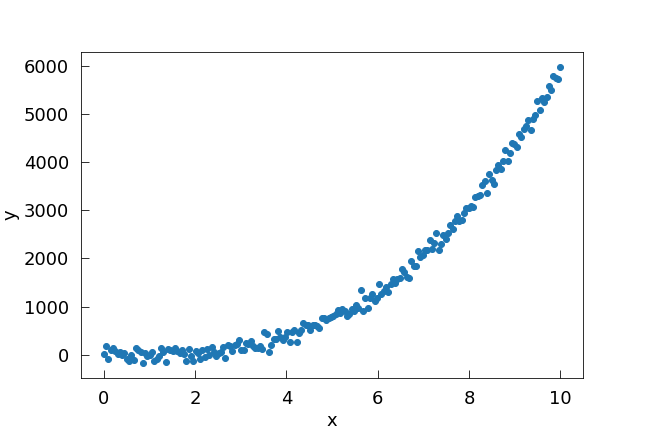

Text(0, 0.5, 'y')

In [18]:
###making toy data
nsample = 200
x = np.linspace(0, 10, nsample)#this is our covariable
X = np.column_stack((x, x**3))#here with have only one real covariable, 
#but we will increase that number by also considering it's cube in our model
beta = np.array([1, -3, 6])#the true value of our paramters associated to our covariables
e = 100*np.random.normal(size=nsample)#for now noise is 0, but play with it

X = sm.add_constant(X)  ##adding the intercept
y = np.dot(X, beta) + e ## making y=1-3x+6x^3 + noise
y_true=np.dot(X, beta)

plt.subplots(figsize = (9,6)) #setup graphical windows
plt.plot(x,y,'o')
plt.xlabel('x')
plt.ylabel('y')

In [19]:
model = sm.OLS(y, X)  ##defining an Ordinary Least Square variable
results = model.fit() ##fitting it

res=results.summary()
print(res)
LMstat , LMpval , Fstat , Fpval = het_white( results.resid , X )
print("\n\tWhite test for heteroscedasticity p-value:" , LMpval)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.976e+04
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          3.61e-245
Time:                        11:53:18   Log-Likelihood:                -1200.6
No. Observations:                 200   AIC:                             2407.
Df Residuals:                     197   BIC:                             2417.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3244     18.464     -0.126      0.9

Let's also plot the result :

<IPython.core.display.Javascript object>


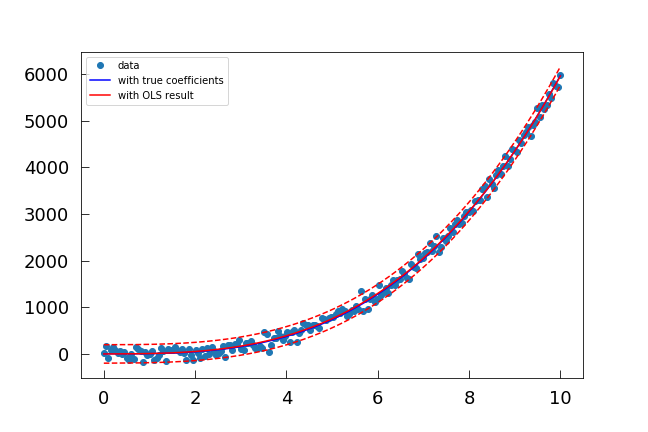

In [20]:
###Plotting the fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# we obtain the predicted values for our model, as well as their 95% intervals
prstd, iv_l, iv_u = wls_prediction_std(results) 

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="with true coefficients")
ax.plot(x, results.fittedvalues, 'r', label="with OLS result")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best',fontsize=10)
#plt.yscale('log')

**Mini-exercise : given these results (plot + result summary), what is your conclusion on this model ?**

These summaries given by statsmodels are great, but they can be a hassle to handle programmatically. Here is a little recipe to transform them in pandas DataFrame.

In [21]:
from io import StringIO

#### a little bit of gymnastic to get this summary saved and usable.
def make_summary_tables( res ):
    """ takes a summary from statsmodel fitting results and turn it into 2 dataFrame.
            - result_general_df : contains general info and fit quality metrics
            - result_fit_df : coefficient values and confidence intervals
    """

    # transform second table to csv and read this as a dataFrame
    result_fit_df = pd.read_csv(StringIO( res.tables[1].as_csv() ), sep=",",index_col=0)

    # first table is trickier because the data is spread on to columns, and there is title line
    L = res.tables[0].as_html().split('\n')
    L.pop(1) # get rid of the title
    tmp = pd.read_html('\n'.join(L) , header=None)[0] # read as a dataframe, but with 4 columns 

    names = list(tmp[0]) + list(tmp[2])[:-2] # columns 0 and 2 are metric names
    values = list(tmp[1]) + list(tmp[3])[:-2] # columns 1 and 3 are the corresponding values
    # NB : I exclude the last 2 elements which are empty 
    
    result_general_df = pd.DataFrame( {'Name': names , 'Value' : values}, index = names , columns=['Value'] )
    
    return result_general_df , result_fit_df

result_general_df , result_fit_df = make_summary_tables( res )

In [22]:
# I have put the overall recap of the fit in a dataframe format so you can use it later
result_general_df

,Value
Dep. Variable:,y
Model:,OLS
Method:,Least Squares
Date:,"Thu, 29 Oct 2020"
Time:,11:53:18
No. Observations:,200
Df Residuals:,197
Df Model:,2
Covariance Type:,nonrobust
R-squared:,0.997


In [23]:
# I have put the outcome of the fit in a dataframe format so you canuse it later
result_fit_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,-2.3244,18.464,-0.126,0.90,-38.736,34.087
x1,2.8079,5.995,0.468,0.64,-9.014,14.630
x2,5.9352,0.061,97.441,0.00,5.815,6.055


# real dataset exercise : model the effect of park frequentation on sparrow nest number with a cubic function


Using data from [TESTING THE RISK-DISTURBANCE HYPOTHESIS IN A FRAGMENTED LANDSCAPE: NONLINEAR RESPONSES OF HOUSE SPARROWS TO HUMANS
Fernández-Juricic(2003),BioOne](https://bioone.org/journals/the-condor/volume-105/issue-2/0010-5422(2003)105%5b0316%3aTTRHIA%5d2.0.CO%3b2/TESTING-THE-RISK-DISTURBANCE-HYPOTHESIS-IN-A-FRAGMENTED-LANDSCAPE/10.1650/0010-5422(2003)105[0316:TTRHIA]2.0.CO;2.short)

In this data set we would like to model the relation between the density of house sparrow nests in a park and how popular a park is.

In [24]:
df=pd.read_csv("Human_nuisance.csv")
y=list(df["Breeding density(individuals per ha)"])
X=list(df["Number of pedestrians per ha per min"])

<IPython.core.display.Javascript object>


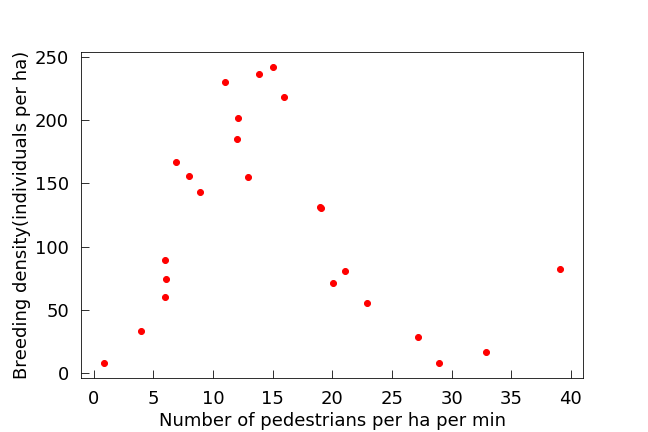

Text(0.5, 0, 'Number of pedestrians per ha per min')

In [25]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(X,y,'ro')
ax.set_ylabel("Breeding density(individuals per ha)")
ax.set_xlabel("Number of pedestrians per ha per min")

Perform an OLS regression analysis on this data, to explain the swallow breeding density (response variable) with the number of pedestrian (covariable).

> The relationship between the two variable implies at most a cubic (\*\*3) relation

In [26]:
df=pd.read_csv("Human_nuisance.csv")
df_nuisance=pd.DataFrame()
df_nuisance["Breeding"]=df["Breeding density(individuals per ha)"]
df_nuisance["Number"]=df["Number of pedestrians per ha per min"]
df_nuisance["Number^2"]=df["Number of pedestrians per ha per min"]**2
df_nuisance["Number^3"]=df["Number of pedestrians per ha per min"]**3
y=df_nuisance["Breeding"]
X=df_nuisance[["Number","Number^2","Number^3"]]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.OLS(y, X)# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)
LMstat , LMpval , Fstat , Fpval = het_white( results.resid , X )
print("\n\tWhite test for heteroscedasticity p-value:" , LMpval)

                            OLS Regression Results                            
Dep. Variable:               Breeding   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     21.63
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           1.73e-06
Time:                        11:53:19   Log-Likelihood:                -120.22
No. Observations:                  24   AIC:                             248.4
Df Residuals:                      20   BIC:                             253.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -103.6962     36.066     -2.875      0.0

<IPython.core.display.Javascript object>


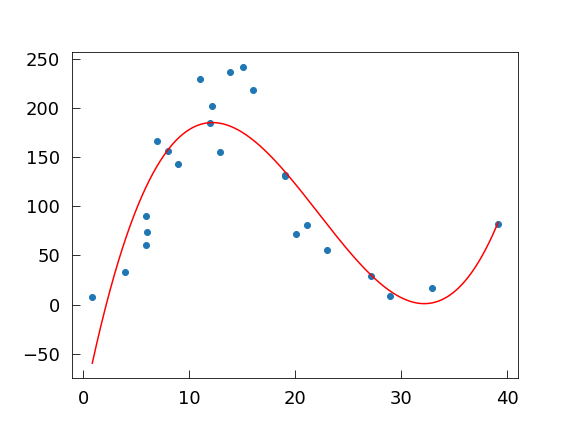

In [27]:
y_d=list(df["Breeding density(individuals per ha)"])
X_d=list(df["Number of pedestrians per ha per min"])
xx=np.arange(min(X_d),max(X_d),0.01)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_d, y_d, 'o', label="data")
ax.plot(xx, [54.2835*r-3.0726*r**2+0.0462*r**3-103.6962 for r in xx], 'r', label="data")


## 1.5 What to do when some hypothesis about OLS are not true

When the homoscedasticity of your data is not true you have a few possibilities:
- you can transform your data so your data become homoscedastic (for example you could use a variance stabilizing transformation, or a simple log transform or other...)
- you can change $S(\beta)$, your loss function, to reweight the different members of that equation by taking into account the discrepancy in terms of variance. That only works if there is no correlation between the error terms. In that case the method is called **Weighted Least Square** and the loss function becomes 
$$S(\pmb\beta)=\sum_i (y_i-f(\pmb X_i,\pmb{\beta}))^2 \rightarrow S(\pmb\beta)=\sum_i \frac{1}{\sigma_i^2} (y_i-f(\pmb X_i,\pmb{\beta}))^2$$
- if there is a correlation between the different error terms then it becomes more complicated, but technics exist such as Generalized Least Square model

**Finally if you know  what statistics your measurement follow, you can bypass all of those problems (and encounter others :-)) by using a maximum likelihood estimation rather than an LS method. By doing so you will have to put yourself in the framework of Generalized Linear Models.**



## 1.6. Model choosing

Most of the time you are not sure of the model you want to fit. You might have a broad idea of the different forms of the function but you don't really know for example what would be the best degree for your poynomial or if all the covariables are actually necessary. Of course you could say "I am keeping the model that fit the best in term of $R^2$". But the question really is : is that bunch of extra parameters that are complexifying my model worth the increase in $R^2$?

We touched that question in 1.4 by asking about the significance of parameters values. Again if you are confident on the noise distribution you are dealing with (let's say it is normally distributed), and you have a function in mind but you don't know if you should include 1,2 or $p$ covariables then the problem is easy: you can use a log-likelihood ratio test.


### Likelihood ratio test (LRT)

We already mentioned the likelihood, or log-likelihood, several time. 

We will not spend too long here on its precise definition, in part because we will discuss it in some details in the next chapter. Suffice to know for now the **likelihood is a metric of goodness of fit of your model to your data** which possess interesting mathematical properties when it comes to comparing different models. 

Furthermore, it is computed for you by `statsmodels.OLS` and is part of the fit summary.


To perform a Likelihood Ratio Test you just have to calculate the difference between the maximised log-likelihood of the two models you are comparing. 
You can estimate the significance of that difference either by using a test statistic (approximate method, which we will show) or by using simulations.

LRT are to be used in the case of **nested function comparisons**. Nested functions are functions that have the same form but differ in the number of parameters used : for example comparing $y=\beta_1 x_1 +c$ and $y=\beta_1 x_1 +\beta_2 x_2 +c$. In this course this will always be the case (but just remember that outside of this course you might want to do other comparison, so be careful).

**Briefly :**

You want to compare model $M_0$ and $M_1$, respectively having $\{\beta_{1,0}\}$ and $\{\beta_{1,2},\beta_{2,2}\}$ as parameters. You want to see if adding this extra parameter $\beta_{2,2}$ is worth it.

The LRT statistics is :

$$2*(l(X;\hat{\beta}_{1,2},\hat{\beta}_{2,2})-l(X;\hat{\beta}_{1,0}))$$

Where the hat represents the maximum likelihood estimates. 

The LRT statistic asymptoptically, for your sample size going to infinity, follows a **chi-square distribution with a number of degree of freedom equal to the difference between the number of parameters in your models**. You have thus access to a P-value which will help you to decide if complexifying your model is worth it. 

Typically this LRT statistic could be viewed as a difference in terms of goodness of fit. If this difference is big compared to the goodness of fit of the model with fewer parameters then it is interesting to keep the complexified model. 

Indeed if this LRT statistic is big then the P-value will be low, and you will tend to reject the null hypothesis that the two models have the same (or non-significatively different) goodness of fit to your data.

> Note how in the LRT statistic I have put the complex model first then the simple model.


To calulate this P-value you can use $1-scipy.stats.chi2.cdf(LRT,df_{M_1}-df_{M_0})$, where $df$ is the number of degree of freedom of the models, equivalent to the number of parameters in our case.

Just to clarify again : **you want to go for the model with the least number of parameters and for which adding more parameters doesn't signicantly increase the goodness of fit**.

#### Example of model choosing : on diabetes

In [52]:
ordered_loglike=['bmi', 's5', 'bp', 's3', 's2']
y=np.array(diabetes['target'])#making this data set into an array
list_co=[]#list of covariable
ordered_loglike_multi=[] # we shall store the regression results there

for p in ordered_loglike:# we will add covariables 1 by 1
    list_co.append(p) # adding a covariable
    
    print("The list of covariables we are making a model with ",list_co)
    
    X=np.array(df_diabetes[list_co]) # focusing on some covariables
    X = sm.add_constant(X) # you probably want an intercept
    model = sm.OLS(y, X) # define your least square object
    results = model.fit() # fitting

    ## we transform the summary to access the log-likelihood of the model
    result_general_df , result_fit_df = make_summary_tables( results.summary() )
    
    AdjR2 = result_general_df['Value']['Adj. R-squared:']
    logLikelihood = result_general_df['Value']['Log-Likelihood:']
    print("\tadjusted R-squared:" , AdjR2 , 'log-likelihood:' , logLikelihood)
    
    # add the list of covariable, the log-likelihood and the summary of the fit to our result table
    ordered_loglike_multi.append(['_'.join(list_co),logLikelihood,result_fit_df]) 
    
# the models are ordered by their number of parameters, and that also corresponds to their likelihood

The list of covariables we are making a model with  ['bmi']
	adjusted R-squared: 0.342 log-likelihood: -2454.0
The list of covariables we are making a model with  ['bmi', 's5']
	adjusted R-squared: 0.457 log-likelihood: -2411.2
The list of covariables we are making a model with  ['bmi', 's5', 'bp']
	adjusted R-squared: 0.47700000000000004 log-likelihood: -2402.6
The list of covariables we are making a model with  ['bmi', 's5', 'bp', 's3']
	adjusted R-squared: 0.48700000000000004 log-likelihood: -2397.7
The list of covariables we are making a model with  ['bmi', 's5', 'bp', 's3', 's2']
	adjusted R-squared: 0.491 log-likelihood: -2395.6


In [53]:
p_value_threshold=0.01## what you would consider as significant or not : 
# i.e if you will consider adding the parameter or not

#we are going through the list of models following their order in goodness of fit
for i in range(1,len(ordered_loglike_multi)): # from model 1 (second model) to the last one
    # We compare this model to the previous one (i-1)
    loglkh1 = ordered_loglike_multi[i  ][1]
    loglkh2 = ordered_loglike_multi[i-1][1]
    LRT = 2*( loglkh1 - loglkh2 )
    # By definition they differ by 1 parameter, so the degree of freedom of the Chi-square distribution is 1
    pval = 1-stats.chi2.cdf( LRT , 1 )#calculating the pvalue that compares the goodness of fit of the two models
    if pval < p_value_threshold:
        print("The log likelihood difference between model {0} and model {1}".format(ordered_loglike_multi[i][0],ordered_loglike_multi[i-1][0]))
        print(" is associated to a P-value={0}\n".format(pval))

    else:
        print("The log likelihood difference between model {0} and model {1}".format(ordered_loglike_multi[i][0],ordered_loglike_multi[i-1][0]))
        print(" is associated to a non-significant P-value={0}\n".format(pval))
        break

The log likelihood difference between model bmi_s5 and model bmi
 is associated to a P-value=0.0

The log likelihood difference between model bmi_s5_bp and model bmi_s5
 is associated to a P-value=3.36436353611802e-05

The log likelihood difference between model bmi_s5_bp_s3 and model bmi_s5_bp
 is associated to a P-value=0.0017451186995287582

The log likelihood difference between model bmi_s5_bp_s3_s2 and model bmi_s5_bp_s3
 is associated to a non-significant P-value=0.040423979336912996



In [54]:
#let's look at our best model
ordered_loglike_multi[3]

['bmi_s5_bp_s3',
 -2397.7,
           coef      std err       t      P>|t|     [0.025     0.975] 
                                                                      
 const    152.1335      2.627     57.916   0.000    146.971    157.296
 x1       555.2795     65.829      8.435   0.000    425.898    684.661
 x2       484.9791     66.684      7.273   0.000    353.918    616.041
 x3       269.6756     62.383      4.323   0.000    147.068    392.283
 x4      -193.9536     61.922     -3.132   0.002   -315.656    -72.251]

# Exo model choosing OLS + loglikelihood : on the sparrow nuisance

Come back to the sparrow dataset (`df_nuisance`).

Find the best model possible (i.e., change the degree of the polynomial we try to fit).

In [55]:
df=pd.read_csv("Human_nuisance.csv")
df_nuisance=pd.DataFrame()
df_nuisance["Breeding"]=df["Breeding density(individuals per ha)"]##[:-2] I tried without the 2 last points

potentialCovariables = []

## adding our covariable from power 1 to power 5
for j in range(1,5+1): # +1 because range excludes the upper limit
    df_nuisance["Number"+"^"+str(j)]=df["Number of pedestrians per ha per min"]**j
    potentialCovariables.append("Number"+"^"+str(j))
   
    
list_co=[]#list of covariable
ordered_loglike_multi=[]
for i in range(len(potentialCovariables)):
    
    # we examine all covariables up to the one of interest
    list_co = potentialCovariables[:i+1]     
    
    y=df_nuisance["Breeding"]
    X=df_nuisance[list_co]#again making it an array 
    X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
    model = sm.OLS(y, X)# we create the least square fit object
    results = model.fit()#we do the actual fit

    ## we transform the summary to access the log-likelihood of the model
    result_general_df , result_fit_df = make_summary_tables( results.summary() )
    
    AdjR2 = result_general_df['Value']['Adj. R-squared:']
    logLikelihood = result_general_df['Value']['Log-Likelihood:']
    print("\tadjusted R-squared:" , AdjR2 , 'log-likelihood:' , logLikelihood)
    
    # add the list of covariable, the log-likelihood and the summary of the fit to our result table
    ordered_loglike_multi.append(['_'.join(list_co),logLikelihood,result_fit_df]) 
    
# the models are ordered by their number of parameters, and that also corresponds to their likelihood

	adjusted R-squared: 0.021 log-likelihood: -136.78
	adjusted R-squared: 0.233 log-likelihood: -133.29
	adjusted R-squared: 0.7290000000000001 log-likelihood: -120.22
	adjusted R-squared: 0.737 log-likelihood: -119.26
	adjusted R-squared: 0.851 log-likelihood: -111.79


In [56]:
p_value_threshold=0.01## what you would consider as significant or not : 
# i.e if you will consider adding the parameter or not

#we are going through the list of models following their order in goodness of fit
for i in range(1,len(ordered_loglike_multi)): # from model 1 (second model) to the last one
    # We compare this model to the previous one (i-1)
    loglkh1 = ordered_loglike_multi[i  ][1]
    loglkh2 = ordered_loglike_multi[i-1][1]
    LRT = 2*( loglkh1 - loglkh2 )
    # By definition they differ by 1 parameter, so the degree of freedom of the Chi-square distribution is 1
    pval = 1-stats.chi2.cdf( LRT , 1 )#calculating the pvalue that compares the goodness of fit of the two models
    if pval < p_value_threshold:
        print("The log likelihood difference between model {0} and model {1}".format(ordered_loglike_multi[i][0],ordered_loglike_multi[i-1][0]))
        print(" is associated to a P-value={0}\n".format(pval))

    else:
        print("The log likelihood difference between model {0} and model {1}".format(ordered_loglike_multi[i][0],ordered_loglike_multi[i-1][0]))
        print(" is associated to a non-significant P-value={0}\n".format(pval))
        break

The log likelihood difference between model Number^1_Number^2 and model Number^1
 is associated to a P-value=0.008242560884641592

The log likelihood difference between model Number^1_Number^2_Number^3 and model Number^1_Number^2
 is associated to a P-value=3.1753732754324915e-07

The log likelihood difference between model Number^1_Number^2_Number^3_Number^4 and model Number^1_Number^2_Number^3
 is associated to a non-significant P-value=0.16585666034291147



In [57]:
#let's look at our best model
ordered_loglike_multi[2]

['Number^1_Number^2_Number^3',
 -120.22,
              coef      std err       t      P>|t|     [0.025     0.975] 
                                                                         
 const      -103.6962     36.066     -2.875   0.009   -178.929    -28.463
 Number^1     54.2835      7.523      7.216   0.000     38.591     69.976
 Number^2     -3.0726      0.441     -6.965   0.000     -3.993     -2.152
 Number^3      0.0462      0.007      6.279   0.000      0.031      0.062]

# Generalized linear model --> to notebook 2

So, previously we saw that under some hypothesis we could use the Oridnary Least Square method to fit a curve. We also saw that if we knew that the errors were normally distributed then this OLS method was equivalent to using another method called Maximum Likelihood. We also mentioned that if the OLS hypothesis were not verified, then we could use what is called a Generalized Linear Model. As you will see this GLM also rely on the Maximum Likelihood method.

First, let's se a typical cases where our OLS is not going to work, and where I am pretty sure you will have some ideas.

#### Practical case 1 : exponential growth of Corona virus infection

In this dataset we follow the spread of covid cases over time. We would like for example to understand what is the growth rate of cases.

In [173]:
df_corona_exp=pd.read_csv('exponential_covid.csv')
df_corona_exp["Days"]=df_corona_exp.index
df_corona_exp.drop("Time",1,inplace=True)
df_corona_exp.head()

,Infections,Days
0,1,0
1,1,1
2,2,2
3,2,3
4,5,4


<IPython.core.display.Javascript object>


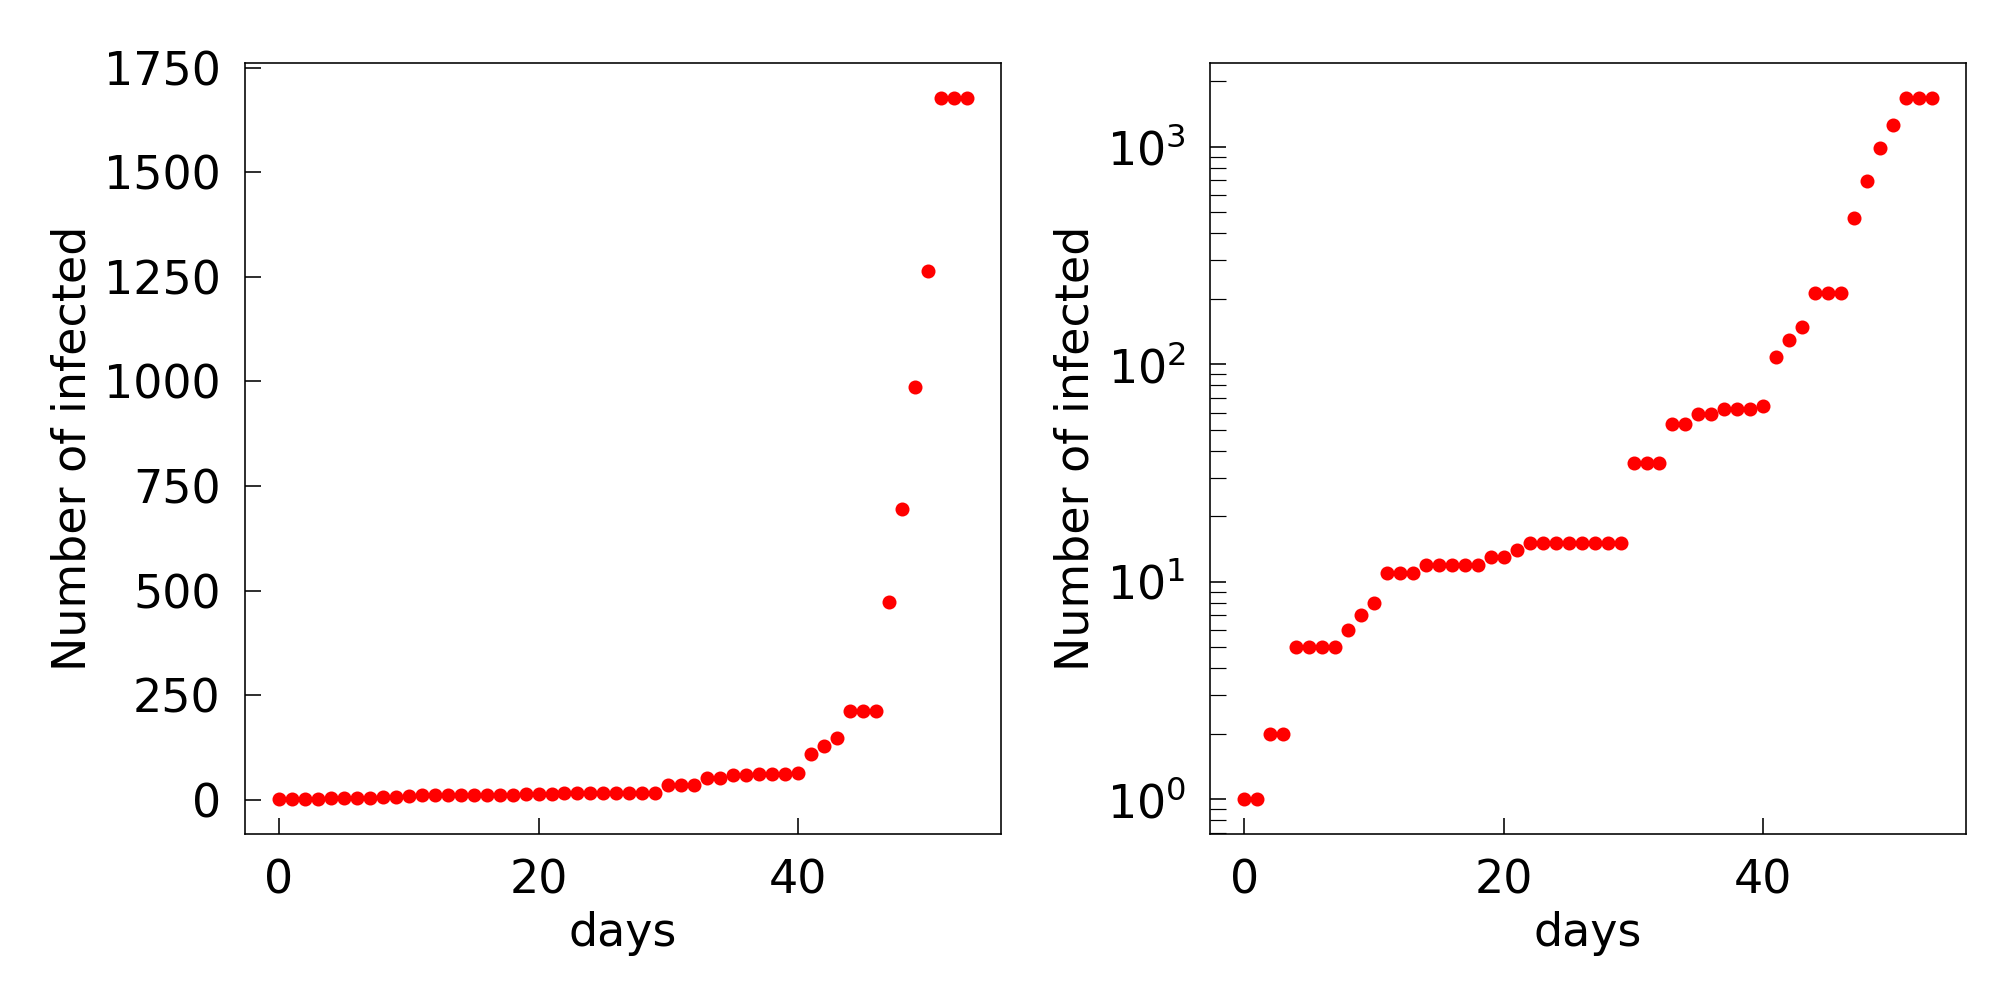

In [178]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
ax[0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'ro')
ax[0].set_xlabel('days')
ax[0].set_ylabel('Number of infected')

ax[1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'ro')
ax[1].set_xlabel('days')
ax[1].set_ylabel('Number of infected')
ax[1].set_yscale('log')
plt.tight_layout()

In the next pair of plots I used a sliding window centered around each point with a stride of 5, to calculate the mean and the variance

<IPython.core.display.Javascript object>


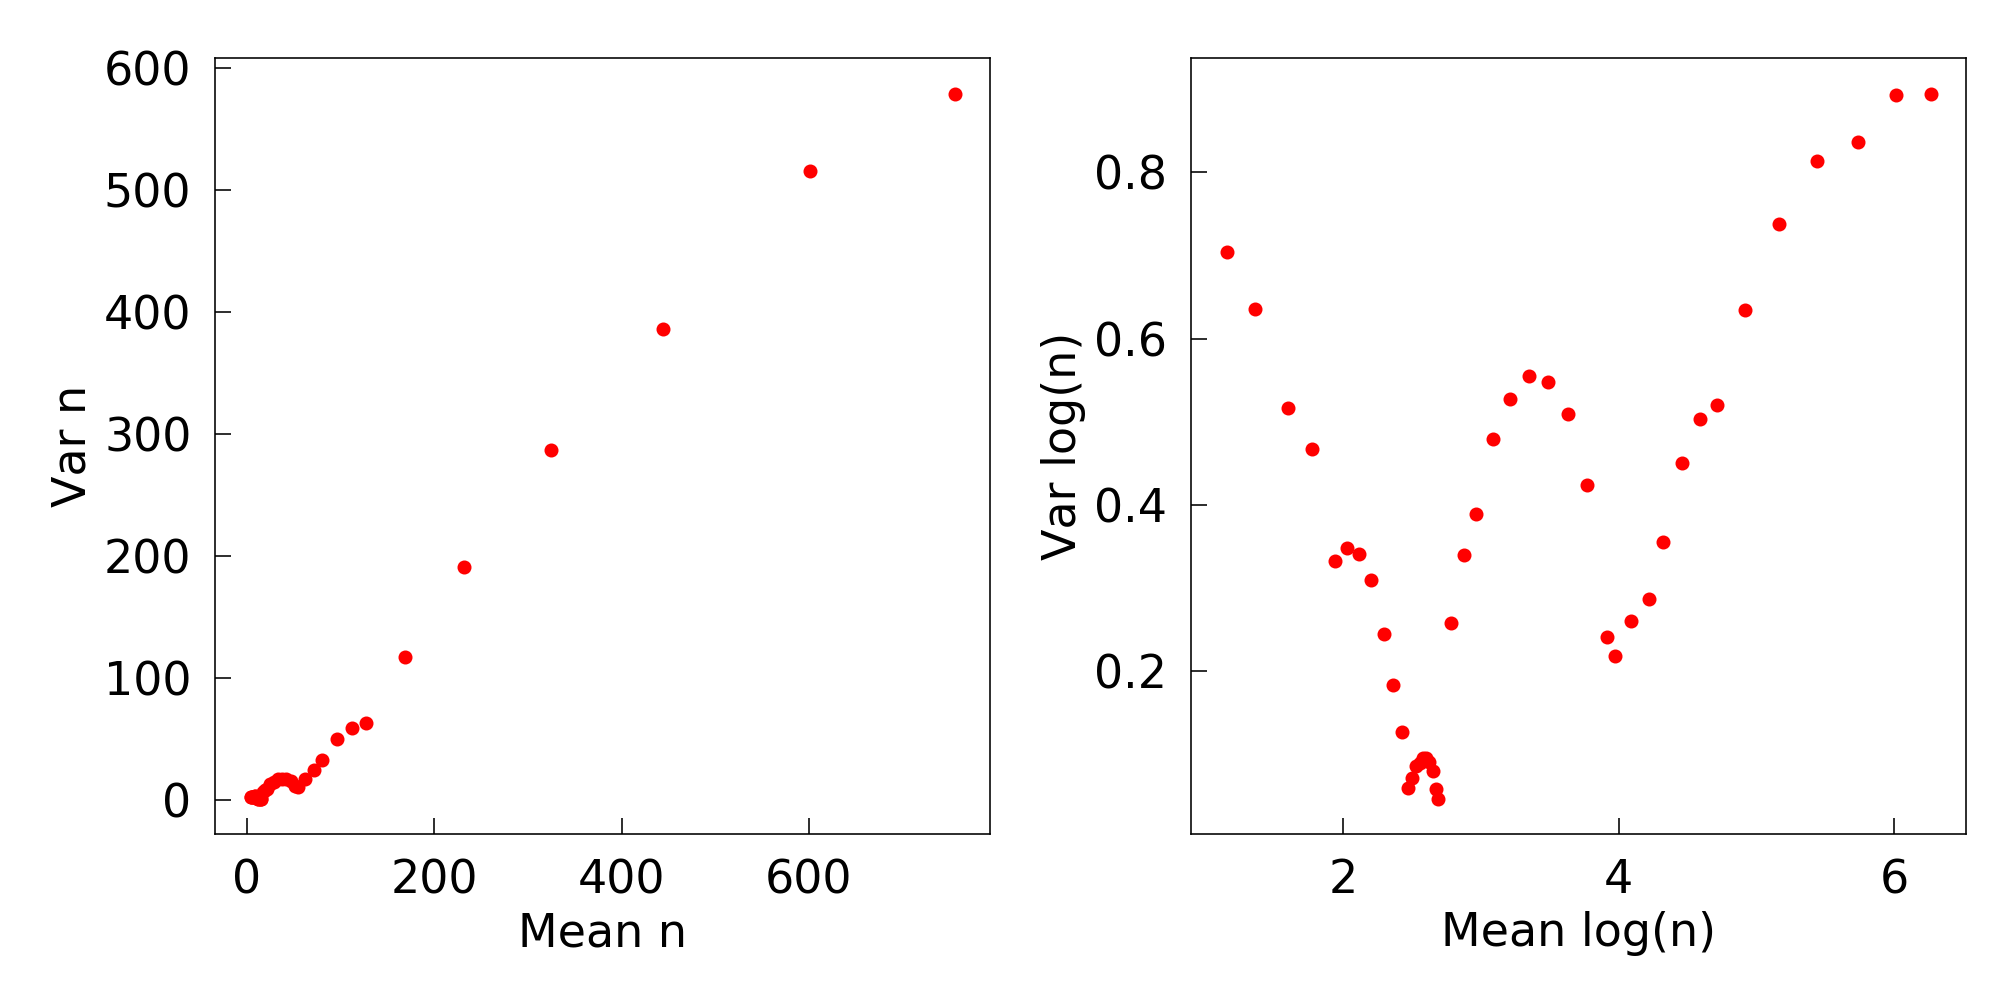

In [309]:
fig, ax = plt.subplots(ncols=2,figsize=(14,7))
interv=5
n=list(df_corona_exp["Infections"])
ax[0].plot([np.mean(n[v-interv:v+interv]) for v in range(interv,len(n)-interv,1)],[np.std(n[v-interv:v+interv]) for v in range(interv,len(n)-interv,1)],'ro')
ax[0].set_xlabel('Mean n')
ax[0].set_ylabel('Var n')


ax[1].plot([np.mean(np.log(n[v-interv:v+interv])) for v in range(interv,len(n)-interv,1)],[np.std(np.log(n[v-interv:v+interv])) for v in range(interv,len(n)-interv,1)],'ro')
ax[1].set_xlabel('Mean log(n)')
ax[1].set_ylabel('Var log(n)')

plt.tight_layout()

So here looking at the data, and with a little bit of domain knowledge we are looking at model of the kind $n(t)=n(0)e^{\beta t}$ where $\beta$ is the growth rate.  With this kind of function it seems impossible to to be able to write $\bar{n(t)}=\pmb t^T\pmb\beta$. Moreover n(t) follow by definition a Poisson statistic (number of events during an interval t), and Poisson random variable have their mean and variance equal : so homoscedasticity is not true. 


Like that it doesn't fit well with the different hypothesis we have seen before . But you can already see what kind of trick we could use to get around it. We could log transform the n. This is really different from what we were doing when transforming the covariables before. This time it really is the response variable that we are going to fit, which is transformed. We are not transforming the $\pmb X$ to increase our descriptional power of $\pmb Y$, but really transforming $\pmb Y$, and by doing so, of course transforming $\pmb X$.

In that case we end up with the following linear relationship:

$$log(n(t))=log(n(0))+\beta t$$

Looking at the relationship between the mean and the var of our newly transformed random variable log(n), we are not sure it could be considered homoscedastic but the variation are kind of small so we could try an OLS to model the log(n(t)).

In [184]:
df_corona_exp["log_infect"]=np.log(df_corona_exp["Infections"])
df_corona_exp.head()

,Infections,Days,log_infect
0,1,0,0.000000
1,1,1,0.000000
2,2,2,0.693147
3,2,3,0.693147
4,5,4,1.609438


In [240]:
import statsmodels
import statsmodels.api as sm
y=df_corona_exp["log_infect"]
X=df_corona_exp["Days"]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.OLS(y, X)# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     510.4
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           1.51e-28
Time:                        13:29:55   Log-Likelihood:                -45.433
No. Observations:                  54   AIC:                             94.87
Df Residuals:                      52   BIC:                             98.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4480      0.154      2.918      0.0

<IPython.core.display.Javascript object>


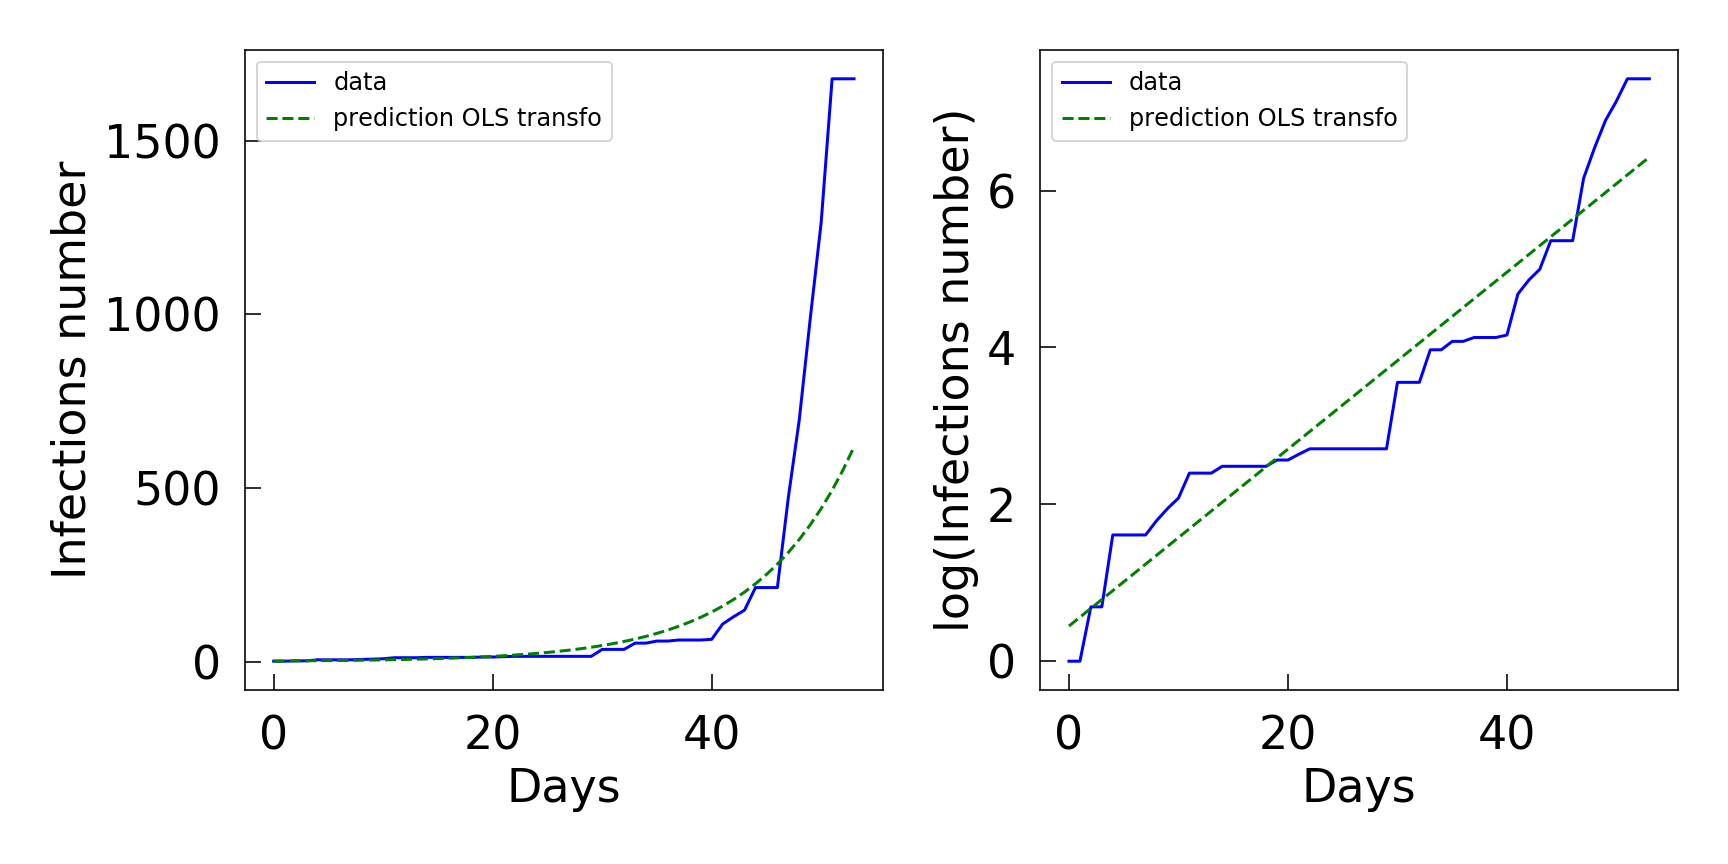

In [306]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'b-',label='data')
ax[0].plot(list(df_corona_exp["Days"]),[np.exp(0.448)*np.exp(0.1128*t) for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Infections number')
ax[0].legend(loc='best',fontsize=12)

ax[1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["log_infect"]),'b-',label='data')
ax[1].plot(list(df_corona_exp["Days"]),[0.448+0.1128*t for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')

ax[1].set_xlabel('Days')
ax[1].set_ylabel('log(Infections number)')
ax[1].legend(loc='best',fontsize=12)
plt.tight_layout()

We will see later on how you just did a significant first step into GLM right now and how we could have go one step further to actually use a GLM. Because, yes, eventhough this already is quite a pretty good model, it is a nice dataset to use the more apropriate GLM than what we did so far. You will see that it will improve our prediction power at later time point, which is not great right now, and which is actually what we are more interested in.

#### Practical case 2 : Relation between the presence of  kyphosis and and a few covariates

Let's try to model the chance to develop kyphosis (abnormally excessive convex curvature of the spine) after undergoing an surgical operation that aims at preventung it, according to features like age of the patient in months, the number of vertebrea involved in abnormal curvature, and where that abnormal curvature start at on the vertebrea. 

In [208]:
df_kyphosis=pd.read_csv('kyphosis.csv')
df_kyphosis["Kyphosis_0_1"]=[1 if v=="present" else 0 for v in df_kyphosis["Kyphosis"]]
df_kyphosis.drop("Kyphosis",1,inplace=True)
df_kyphosis.head()

,Age,Number,Start,Kyphosis_0_1
0,71,3,5,0
1,158,3,14,0
2,128,4,5,1
3,2,5,1,0
4,1,4,15,0


<IPython.core.display.Javascript object>


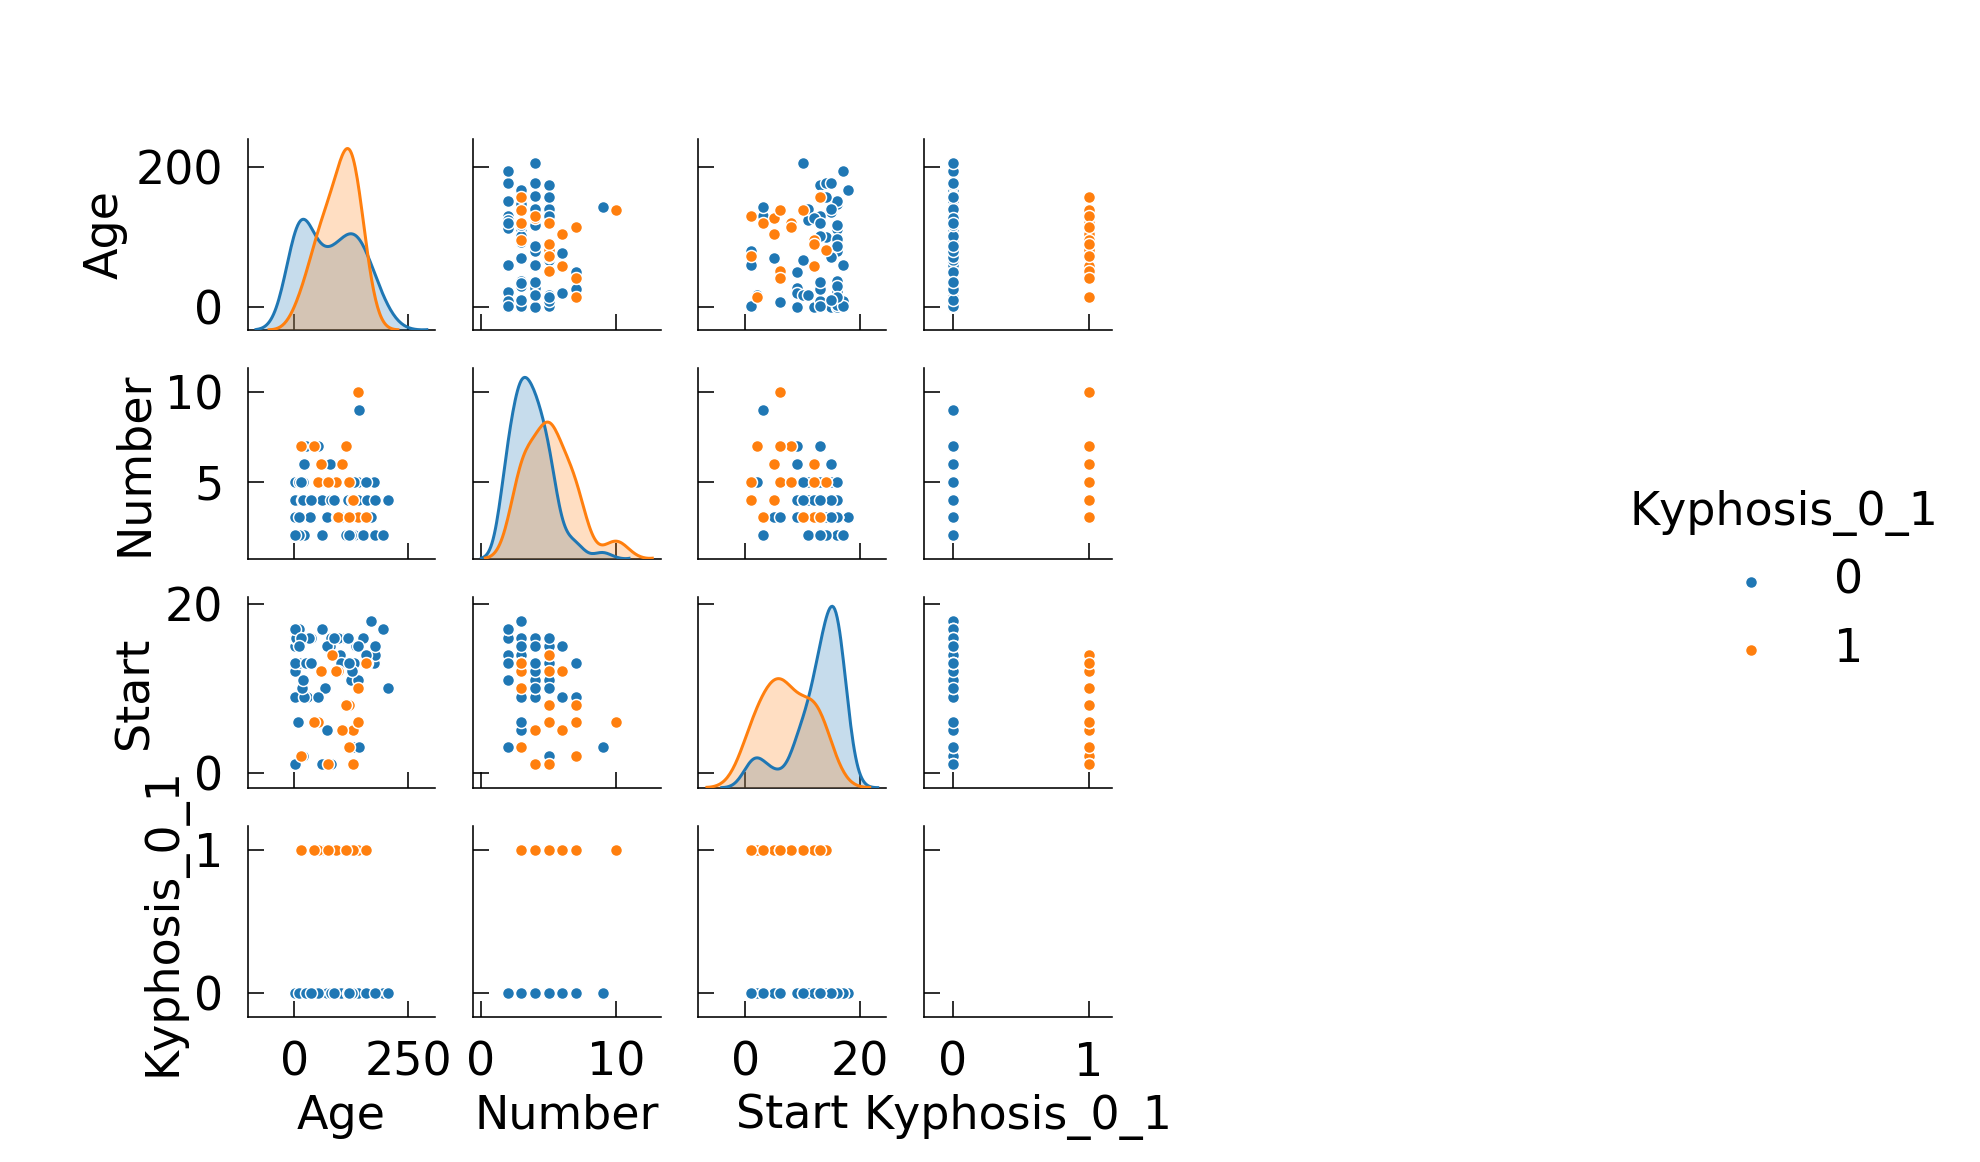

/Users/boyer0000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


In [295]:

sns.pairplot(df_kyphosis,hue="Kyphosis_0_1",height=0.8,aspect=1)

plt.tight_layout()

Here the variable we are interested in is either 0 or 1, and could be seen as the outcome of a bernouilli experiement as it is a binary choice. So inherently you already run into a problem here : how do you write a continuous linear function that will give you values between 0 and 1 (close to zero when kyphosis is absent and close to one when kyphosis is present).... Moreover, again, since you have a bernouilli random variable your mean and your variance are dependant... How are we going to model the absence or presence of kyphosis?


Once again a way to start tackling your problem is to tranform your variable of interest, here kyphosis being present or not. Let's write p the probablity that kyphosis is present (Y=1) and thus 1-p is the probablity that kyphosis is absent (Y=0). In a bernouilli statistic this p also stand for the average of having Y=1.

The transformation we are going to look at is the log transformed of the odd ratio (why? you will understand in a few lines)

$$ln{\frac{p_i}{1-p_i}}=\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j}=\pmb X^T\pmb\beta$$

which translates to

$$p_i=\frac{1}{1+e^{-(\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j})}}$$

So this last equation shows you how we transformed our linear combination of covariables into an outcome between 0 and 1 that relates to the mean of a Bernouilli distribution (if you remember that before we work on relate linearly our covariable to the mean of a guassian you might see where I am going with that, if not no worries).


You can see that we change quite a lot the variable of interest, now it's p and it's not an integer just like our Kyphosis_0_1. Here more than before we drastically shift from modeling the variable to modeling its mean. Also we can not straight away from Kyphosis_0_1 to p (but at least I can show you why it doesn't work). We already know that our variable is coming from a bernouilli experiment. So a good approach would be to fit a bernouilli distribution with parameter (mean) $p_i=\frac{1}{1+e^{-(\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j})}}$, along the curve of our data (juste like what we did for the maximum likelihood with gaussian noise).

As you will see this is exactly what GLM does



First let's see how using OLS here makes no sense

In [254]:
import statsmodels
import statsmodels.api as sm
y=df_kyphosis["Kyphosis_0_1"]
X=df_kyphosis[["Age","Number","Start"]]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.OLS(y, X)# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                            OLS Regression Results                            
Dep. Variable:           Kyphosis_0_1   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     8.900
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           3.91e-05
Time:                        13:42:15   Log-Likelihood:                -30.107
No. Observations:                  81   AIC:                             68.21
Df Residuals:                      77   BIC:                             77.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2612      0.193      1.351      0.1

/Users/boyer0000/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<IPython.core.display.Javascript object>


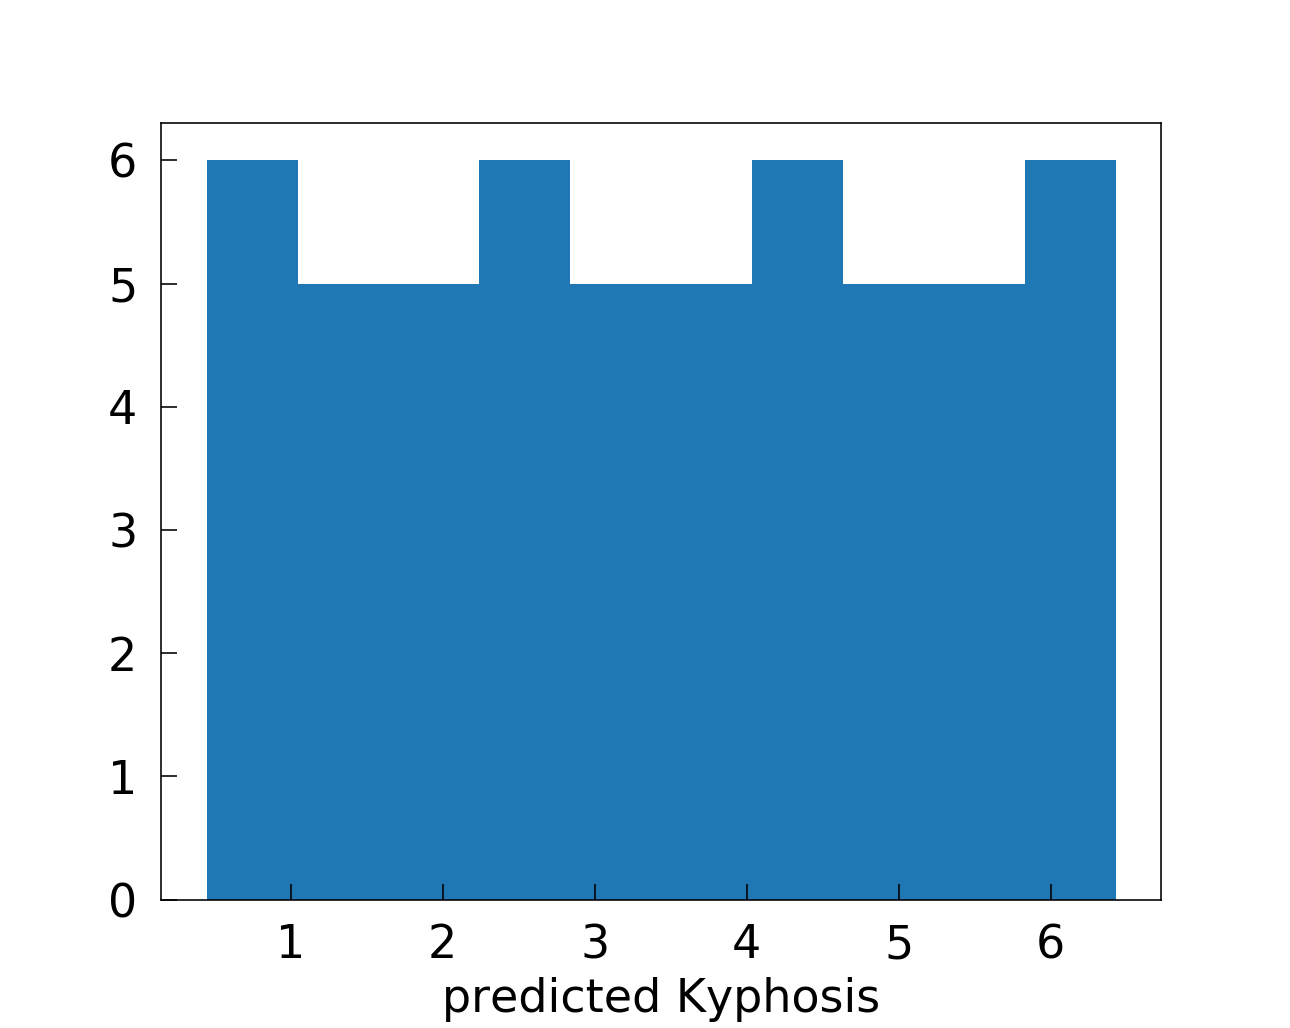

Text(0.5, 0, 'predicted Kyphosis')

In [247]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(list(results.fittedvalues),10)
ax.set_xlabel("predicted Kyphosis")


Those are some irrational values for Kyphosis_1_0

### Let's define what is the modeling process behind GLM

If you remember, to use our Maximum Likelihood Estimator method, we spent a lot of time before saying that we were looking to solve a very specific kind of problem : one where we wanted to fit the mean of $\pmb Y_i$ knowing some value $\pmb X_i$ , and that there was some gaussian noise ($\pmb\mu=0$,$\sigma^2\mathbb{1}=\sigma^2$ to simplify the notation and to emphasize that there is homoscedasticity and no covariance)(still the notation are confusing here... ineed to investigate) around the mean of $\pmb Y_i$.

In mathematical term we were modeling our problem with the following distribution:

$$P(\pmb Y_i|\pmb X_i)=\mathcal{N}(\pmb X_i^{T}\pmb\beta,\sigma^2)$$

On which we were using Maximum Likelihood Estimation 

Thus so far, we have restricted ourselves to purely straightforward linear relations between the mean of $\pmb Y_i$ conditional to $\pmb X_i$ i.e.:

$$\mu(\pmb X_i)=\mathbb{E}(\pmb Y_i|\pmb X_i)=(\pmb X_i^{T}\pmb\beta)$$

We have also only looked at case where the noise was normaly distributed : hence the $\mathcal{N}$ above. 

Under some conditions (i.e your random component is part of the exponential distribution family) you can relax those conditions.

Remember, as we want to use linear models the only thing we can not change is our fitting using $\pmb X_i^{T}\pmb\beta$. But this linear relationship doesn't ahve to apply to the conditional mean $\mu(\pmb X_i)$ but instead to a function of that conditional mean:

$$g(\mu(\pmb X_i))=\pmb X_i^{T}\pmb\beta$$

g is called the link function, and we wil investigate a little bit more what it can be and why it is usefull. 


Or we could also look at more general distribution to model our the noise induced by the interaction between our $\pmb Y_i$ and $\pmb X_i$:

$$P(\pmb Y_i|\pmb X_i)=\mathcal{D}(g^{-1}(\pmb X_i^{T}\pmb\beta),\sigma^2)$$

Where $\mathcal{D}$ is a distribution that make sense to model our $\pmb Y$ random variable, and $g^{-1}$ the inverse of the link function.

And one top of that we could still work with our Maximum Likelihood Estimator method.



**So in our first example about exponential growth of Covid cases GLM would have perfom a maximum likelihood on the following distribution:**

$$P(n(t)|t)=\mathcal{P}(n(0)e^{\delta t})$$

Which is a poisson distribution ($\mathcal{P}$) with mean $n(t)=n(0)e^{\delta t}$, where you should recognize the function $g^{-1}:\pmb t^{T}\pmb\beta\rightarrow n(0)e^{\beta t}$, or $g:n(t) \rightarrow log(n(0))+\delta t$


**In our second example about kyphosis GLM would also simply perform maximum likelihood on the following distribution:**


$$P(\pmb K_i|\pmb X_i)=\mathcal{B}(\frac{1}{1+e^{-(\beta_{0}+\Sigma^{n}_{j=1}\beta_{j}x_{j})}})$$

Where $\mathcal{B}$ is the Bernouilli distribution

#### Let's implement our max likelihood and see how stats model can do the same for us

In [258]:
df_corona_exp.keys()

Index(['Infections', 'Days', 'log_infect'], dtype='object')

In [279]:
import scipy as sc

def log_poisson_distri(x,lambda_):
    try:
        result=np.log(lambda_)*x-lambda_-np.log(np.math.factorial(x))
    except:
        result=np.log(lambda_)*x-lambda_-(x*np.log(x)-x)
    return result


def maxlikelihood1(para,list_x,list_t):
    su=0
    #print(para)
    for x,t in zip(list_x,list_t):
        lambda_=para[0]*np.exp(para[1]*t)
        #print(lambda_)
        su+=log_poisson_distri(x,lambda_)
    return -su


p1_1=sc.optimize.fmin(maxlikelihood1,[1,1],args=(list(df_corona_exp["Infections"]),list(df_corona_exp["Days"]),),full_output=True)

Optimization terminated successfully.
         Current function value: 771.284279
         Iterations: 88
         Function evaluations: 164


In [294]:
print('Initial count: ',p1_1[0][0],'    Growth rate:',p1_1[0][1])

Initial count:  0.06798165172913803     Growth rate: 0.19227434096661228


In [268]:
import statsmodels
import statsmodels.api as sm
y=df_corona_exp["Infections"]
X=df_corona_exp["Days"]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.GLM(y, X, family=sm.families.Poisson())# we create the least square fit object
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Infections   No. Observations:                   54
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -854.83
Date:                Tue, 20 Oct 2020   Deviance:                       1423.8
Time:                        15:31:32   Pearson chi2:                 2.72e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6891      0.092    -29.212      0.0

As a side note, in this summary, you don't see those F-statistic and t-test reports. Of course, since the noise is not normally distributed anymore.

Instead of the t- statistic you get a z static. This z statistics is comming from a Wald test, with the null hypothesis being that the estimate is 0. This Wald test uses the curvature of the log-likelihood for it to be computed and the confidence interval on the estimators as well as it's standard error, are also derived from this curvature.

You might have also notice that there is no $\pmb R^2$ anymore. Instead you have the concept of deviance. It is a way to generalize the concept of $\pmb R^2$ and could be sumurized as the log likelihood ratio ($2*(l(X;\hat{\pmb\beta})-l(X;\hat{\beta}_{0}))$) with a null model only having an intercept ( in the $\pmb R^2$ we were also comparing the explanatory capability of our model to a null model with only an intercept).

Finally the Pearson chi2 is not important here as it is a test relevant only when your response variable is categorical.



<IPython.core.display.Javascript object>


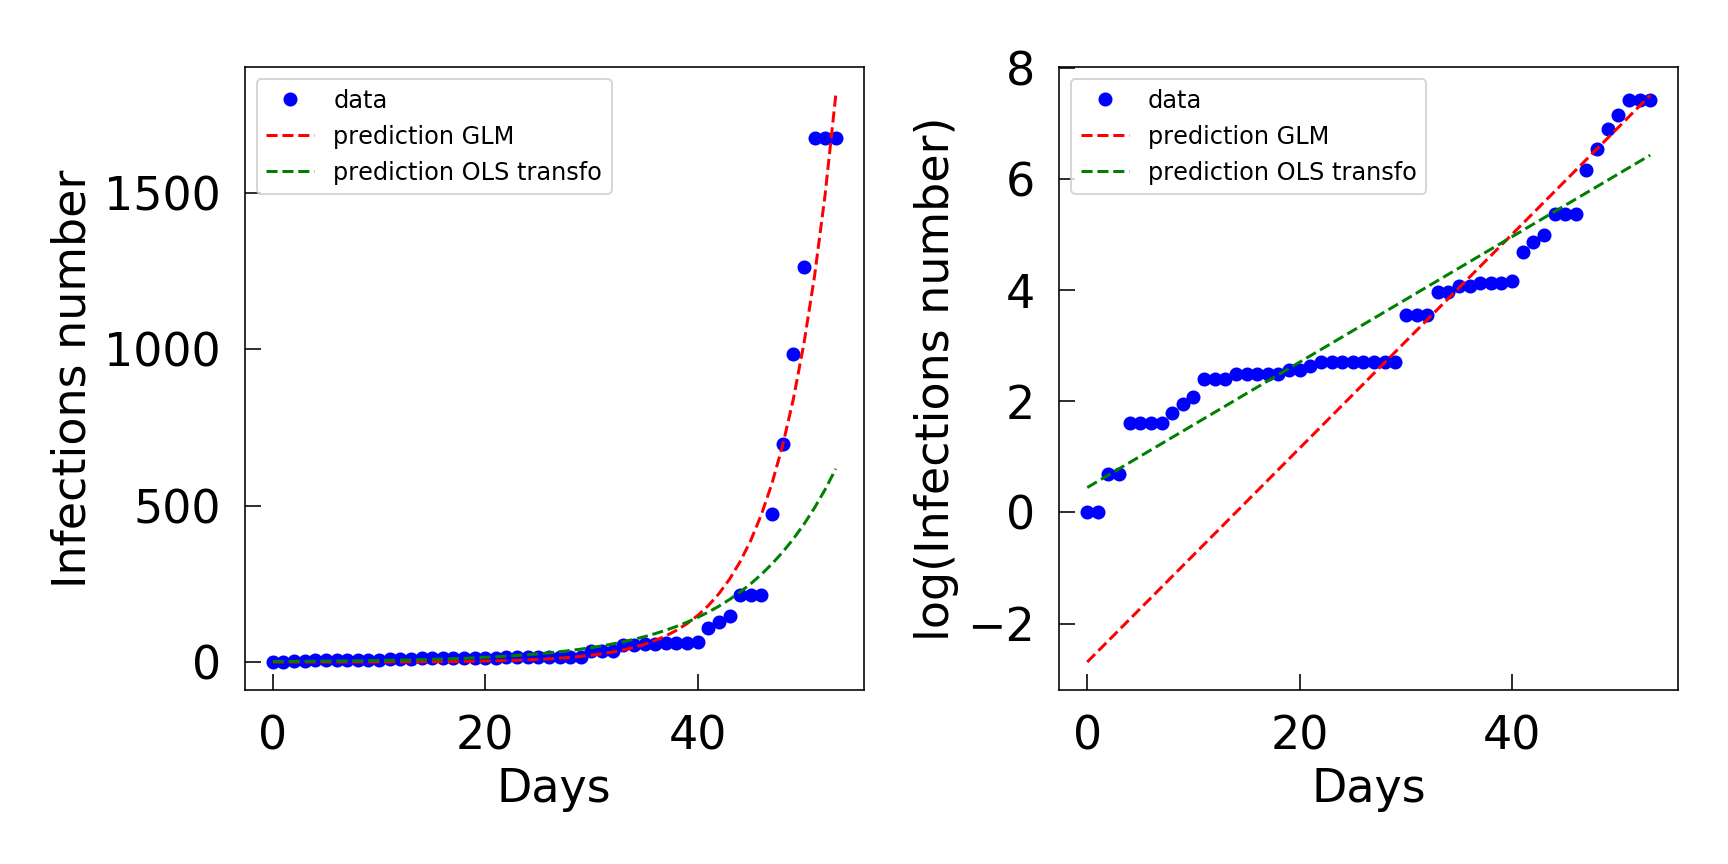

In [308]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(list(df_corona_exp["Days"]),list(df_corona_exp["Infections"]),'bo',label='data')
ax[0].plot(list(df_corona_exp["Days"]),[np.exp(-2.6891)*np.exp(0.1923*t) for t in list(df_corona_exp["Days"])],'r--',label='prediction GLM')
ax[0].plot(list(df_corona_exp["Days"]),[np.exp(0.448)*np.exp(0.1128*t) for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Infections number')
ax[0].legend(loc='best',fontsize=12)

ax[1].plot(list(df_corona_exp["Days"]),list(df_corona_exp["log_infect"]),'bo',label='data')
ax[1].plot(list(df_corona_exp["Days"]),[-2.6891+0.1923*t for t in list(df_corona_exp["Days"])],'r--',label='prediction GLM')
ax[1].plot(list(df_corona_exp["Days"]),[0.448+0.1128*t for t in list(df_corona_exp["Days"])],'g--',label='prediction OLS transfo')

ax[1].set_xlabel('Days')
ax[1].set_ylabel('log(Infections number)')
ax[1].legend(loc='best',fontsize=12)
plt.tight_layout()

Our new model, taking into account the Poisson statistic of our response variable is doing way better (mainly in the important exponential phase)!!!

In [459]:
y=df_kyphosis["Kyphosis_0_1"]
X=df_kyphosis[["Age","Number","Start"]]#again making it an array 
X = sm.add_constant(X)#the model doesn't include an intercept automatically so we creat one
model = sm.GLM(y, X,family=sm.families.Binomial())# we use binomial here eventhough our cariable is Bernouilli. But 
#Binomial with number of try =1 is Brenouilli, and since we are not providing a number of tries here, the function
#understand that  we want indeed Bernouilli
results = model.fit()#we do the actual fit

res=results.summary()
print(res)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Kyphosis_0_1   No. Observations:                   81
Model:                            GLM   Df Residuals:                       77
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30.690
Date:                Thu, 22 Oct 2020   Deviance:                       61.380
Time:                        13:28:28   Pearson chi2:                     70.3
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0369      1.450     -1.405      0.1

A few words about Pearson chi square here or is it too much?

<IPython.core.display.Javascript object>


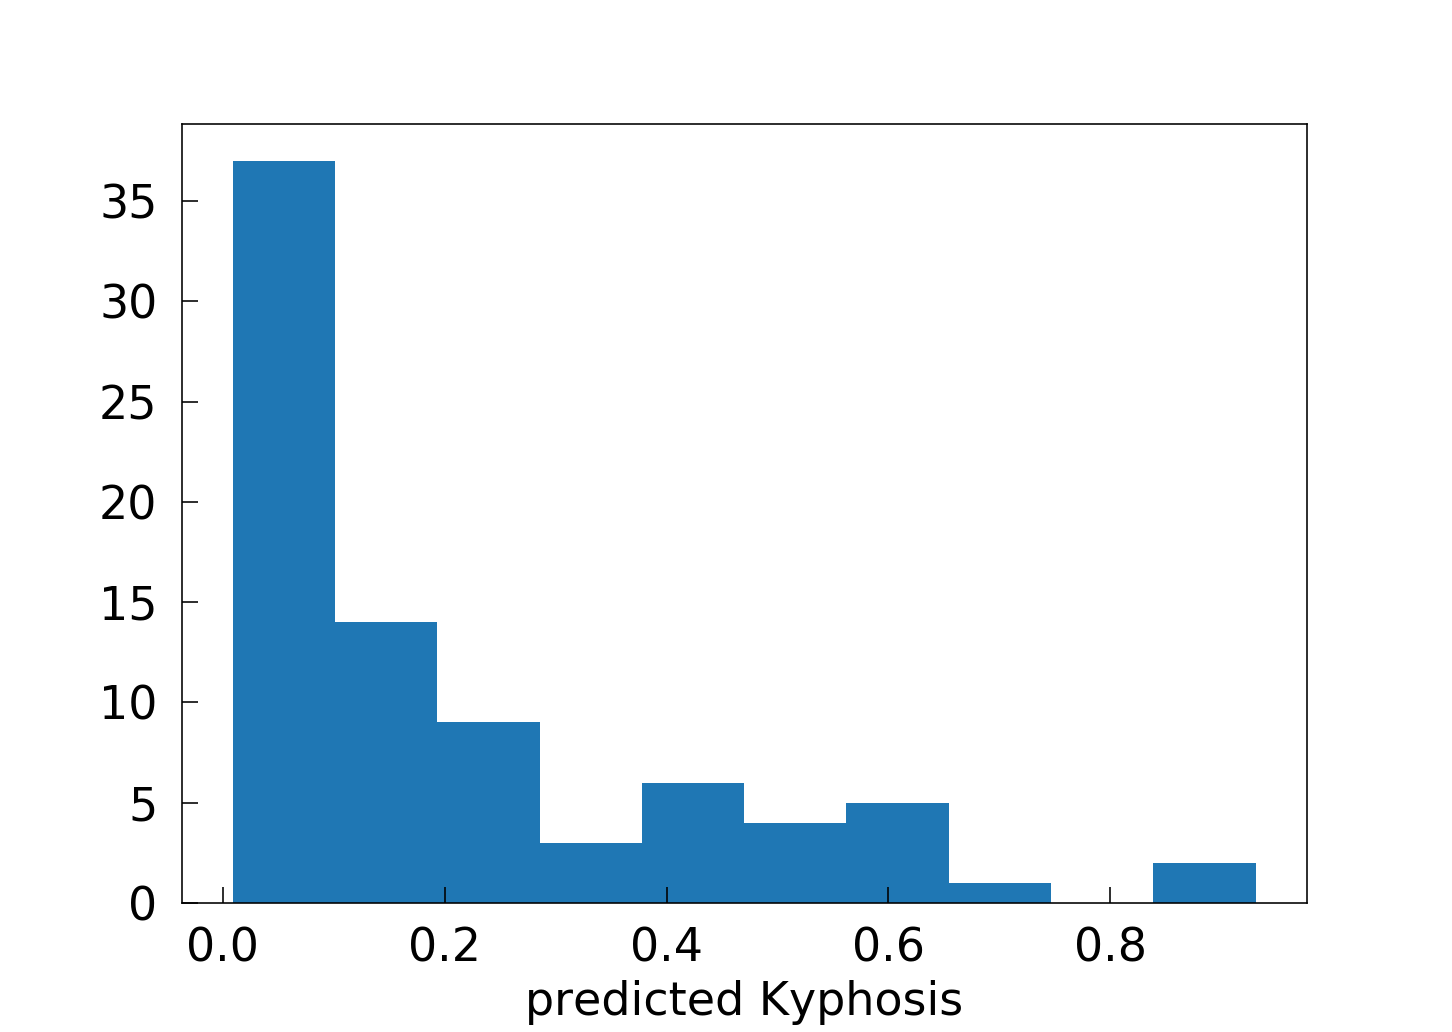

Text(0.5, 0, 'predicted Kyphosis')

In [291]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(list(results.fittedvalues),10)
ax.set_xlabel("predicted Kyphosis")

For each patient we have now a probability that this patient will develop Kyphosis. From here we can put a threshold that will tip our decision to **classify** our patient as prone to develop Kyphosis or not.

Notice the use of the word classify. Classification is a notion that we will develop next, from a machine learning perspective. But remember that in that particular case called classification by logistic regression, under the hood the problem is still a problem of regression through a  modelisation using Generalised Linear Model.

We will spend some time introducing key concepts of the classical machine learning framework, first through classification, involving or not under the hood a regression, or even regression in the framework of machine learning.


# Exo GLM : dose response?

In the following dataset we would like to model the death rate of beetles due to some pesticide concentration.

In [448]:
df_beetles=pd.read_csv('beetle.csv')
#df_beetles["odd"]=[df_beetles["ndied"][l]/df_beetles["nalive"][l] for l in range(len(df_beetles["ndied"]))]
df_beetles.head(100)

,Unnamed: 0,dose,nexp,ndied,prop,nalive
0,1,49.1,59,6,0.102,53
1,2,53.0,60,13,0.217,47
2,3,56.9,62,18,0.290,44
3,4,60.8,56,28,0.500,28
4,5,64.8,63,52,0.825,11
5,6,68.7,59,53,0.898,6
6,7,72.6,62,61,0.984,1
7,8,76.5,60,60,1.000,0


<IPython.core.display.Javascript object>


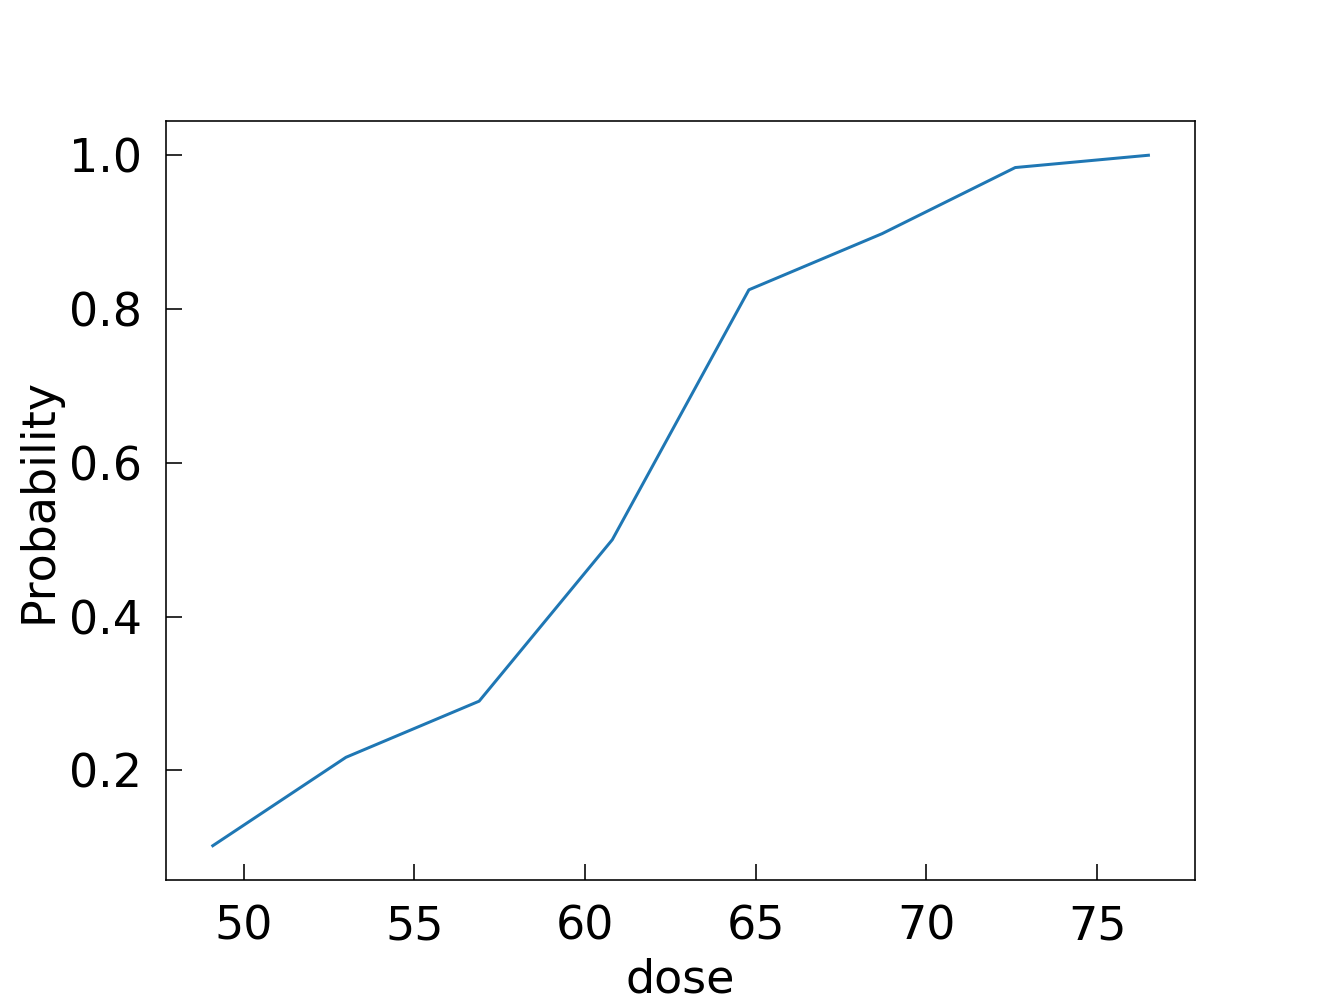

Text(0, 0.5, 'Probability')

In [463]:
fig, ax = plt.subplots(ncols=1,figsize=(6,6))
ax.plot(list(df_beetles["dose"]),list(df_beetles["prop"]))
ax.set_xlabel('dose')
ax.set_ylabel('Probability')

In [457]:

y=df_beetles[["ndied","nalive"]]#since we want our radom variable to be represented by a binomial we need to parameters
#to define a binomial.

X=df_beetles["dose"]
X = sm.add_constant(X)
model = sm.GLM(y, X,family=sm.families.Binomial())
results = model.fit()

res=results.summary()
print(res)

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['ndied', 'nalive']   No. Observations:                    8
Model:                             GLM   Df Residuals:                        6
Model Family:                 Binomial   Df Model:                            1
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -16.791
Date:                 Thu, 22 Oct 2020   Deviance:                       7.3849
Time:                         13:17:19   Pearson chi2:                     6.52
No. Iterations:                      6                                         
Covariance Type:             nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.8230      1.290    -11.49

<IPython.core.display.Javascript object>


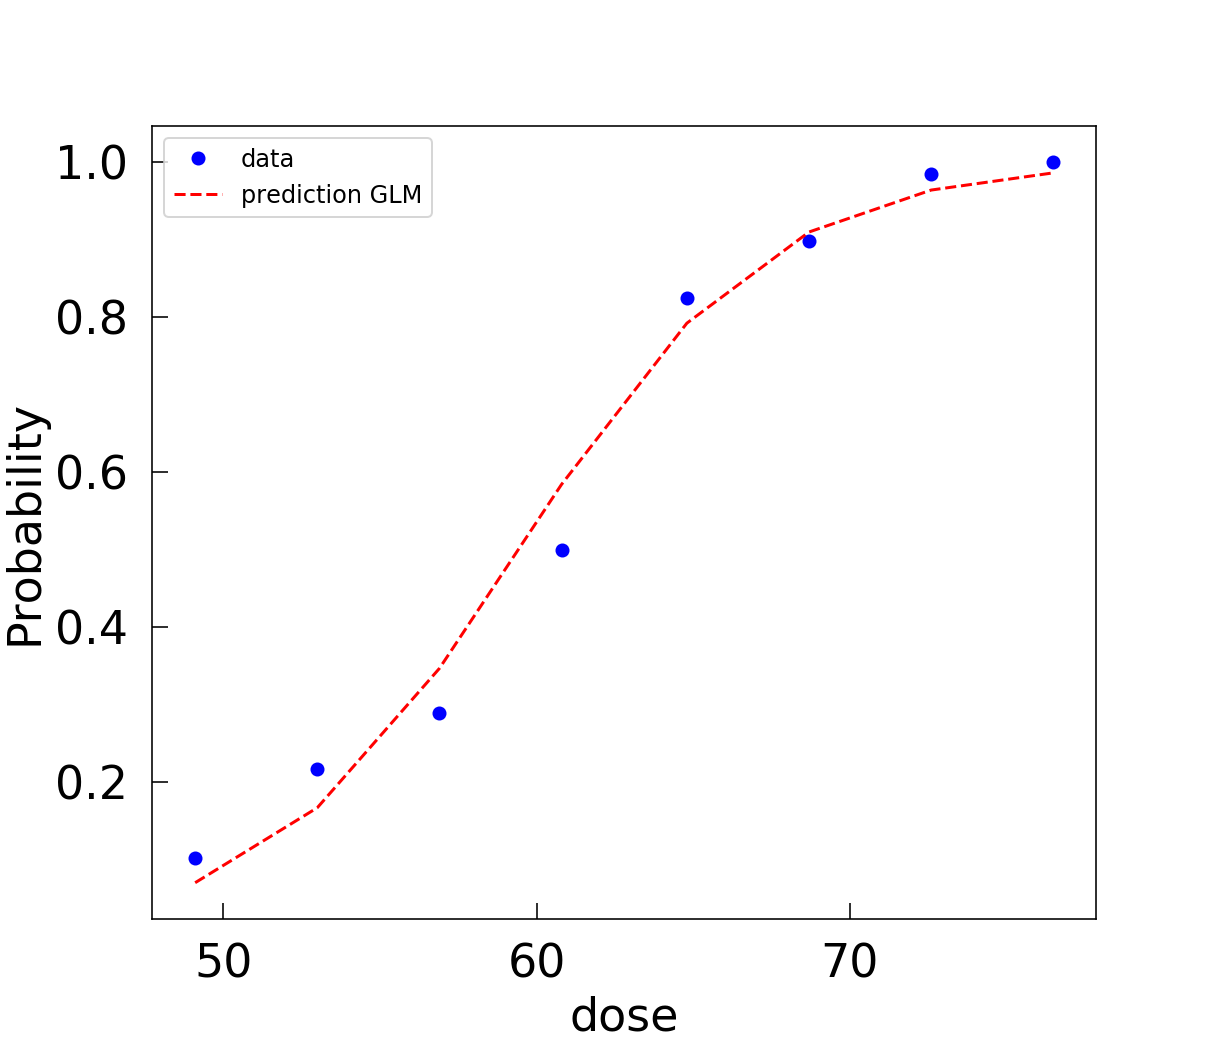

In [461]:

fig, ax = plt.subplots(ncols=1,figsize=(6,6))
ax.plot(list(df_beetles["dose"]),list(df_beetles["prop"]),'bo',label='data')
ax.plot(list(df_beetles["dose"]),[ 1./(1+np.exp(-(-14.8230+0.2494*t)))for t in list(df_beetles["dose"])],'r--',label='prediction GLM')

ax.set_xlabel('dose')
ax.set_ylabel('Probability')
ax.legend(loc='best',fontsize=12)
